# Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from neuralprophet import NeuralProphet
import warnings
import pmdarima as pm
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.cluster import SpectralClustering
from spectralcluster import SpectralClusterer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.metrics import r2_score


 # Phase 2: Provisioning

## Importing Dataset

Using glob we scan the directory of a local folder, getting all files in the process. Using regex we filter out any file type that isn't .csv. We name all files apropriately, read the file and cast them to the appropriate variables. 

In [186]:
## Find all .csv in specified directory
# directory path
dir = r"project_datasets\\"
# glob finds and puts all the file paths into a list
all_files = glob.glob(dir + "*.csv")

In [187]:
## Using RegEx take the name and format it (Format => "df_A")
pattern = re.compile(r'(?<=\\)(.*?)(?=\.)')
def get_file_names(x):
    files = x
    saved = []
    for file in files:
        for name in re.findall(pattern, file):
            name = name.replace("data","df")
            ## .lower() could be removed it's just that our existing document uses lower case (df_a, df_d)
            name = name.lower()
            saved.append(name)
    return saved

In [188]:
## Read all the file name and paths and assign them to variable
dataframe_names = get_file_names(all_files)
for index, item in enumerate(dataframe_names):
    globals()['%s' % item] = pd.read_csv(all_files[index])

In [189]:
print("Available Dataframes:")
print(dataframe_names)

Available Dataframes:
['df_a', 'df_aa', 'df_ab', 'df_ac', 'df_ad', 'df_b', 'df_c', 'df_d', 'df_e', 'df_f', 'df_g', 'df_h', 'df_i', 'df_j', 'df_k', 'df_m', 'df_n', 'df_o', 'df_p', 'df_q', 'df_r', 'df_s', 'df_t', 'df_u', 'df_v', 'df_w', 'df_x', 'df_y', 'df_z']


## Converting our dataframes to Time Series

We convert the EventDt column in each avaiable dataframe to DateTime format, after which we set it as an index and then we resmaple the data on a 5 minute frequency.
Addtionally we add a daily, weekly and monthly variant of each dataframe that assist us in the data analysis at a later point in this notebook.

In [190]:
## Convert all column types to date_time and transform dataframes to time-series
for item in dataframe_names:
    globals()['%s' % item]["EventDt"] = pd.to_datetime(globals()['%s' % item]["EventDt"])
    globals()['%s' % item] = globals()['%s' % item].set_index(globals()['%s' % item]["EventDt"])
    globals()['%s' % item] = globals()['%s' % item].resample(rule="5T").mean()

In [191]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315647 entries, 2018-11-18 16:10:00 to 2021-11-18 16:00:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Temp    258390 non-null  float64
dtypes: float64(1)
memory usage: 4.8 MB


In [192]:
## Added additional dataframes with resampled data in different formats (daily, weekly, monthly)
for item in dataframe_names:
    globals()['%s_daily' % item] = globals()['%s' % item].resample(rule="D").mean()
    globals()['%s_weekly' % item] = globals()['%s' % item].resample(rule="W").mean()
    globals()['%s_monthly' % item] = globals()['%s' % item].resample(rule="M").mean()

## Visualisation 

Before we went any farther with our research, we wanted to see what each gadget was doing and if it was being read correctly.

Text(0.5, 1.0, 'Linear graph')

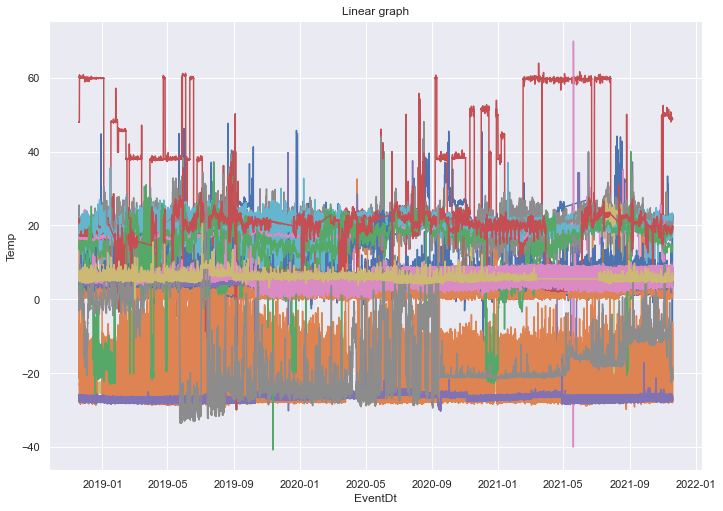

In [9]:
#pic size
sns.set(rc={'figure.figsize':(11.7,8.27)})
#fix the date and maybe zoom in or smt
data = [df_a,df_aa,df_ab,df_ac,df_ad,df_b,df_c,df_d,df_e,df_f,df_g,df_h,df_i,df_j,
        df_k,df_m,df_n,df_o,df_p,df_q,df_r,df_s,df_t,df_u,df_v,df_w,df_x,df_y,df_z]

fig, ax = plt.subplots()

for dataset in data:
    sns.lineplot(x='EventDt', y='Temp', data=dataset, ax=ax) #first dataset

plt.title("Linear graph")

As can be observed, the representation of each sensor is a jumble, making it difficult to understand what is going on within. To approach the analysis through this research, we will first compile average temperatures for each device to evaluate where they stand from freezing to warming.

## Average Temperature Dictionary

To cut-down on load times, instead of plotting each dataframe values directly, we create a dictionary with the names and average temperature for each of our devices. Said dictionary is later plotted using SeaBorn barplot.

In [10]:
average_temps = []
for item in dataframe_names:
#     mean_temp = globals()['%s' % item]["Temp"].mean()
    mean_temp = globals()['%s' % item]["Temp"].quantile(.35)
    average_temps.append(mean_temp)
    
mean_temp_dev_dictionary = {"Device":dataframe_names,"Mean Temperature":average_temps}
mean_temp_dev = pd.DataFrame.from_dict(mean_temp_dev_dictionary)
mean_temp_dev.T

0      1      2      3      4     5      6      7   \
Device             df_a  df_aa  df_ab  df_ac  df_ad  df_b   df_c   df_d   
Mean Temperature  17.33  -21.0  18.83  21.87  19.41  5.55  14.15  16.84   

                     8      9   ...     19    20    21    22     23    24  \
Device             df_e   df_f  ...   df_q  df_r  df_s  df_t   df_u  df_v   
Mean Temperature -24.13  21.75  ...  18.89  4.53  0.96  13.0  19.53  4.14   

                    25    26    27    28  
Device            df_w  df_x  df_y  df_z  
Mean Temperature  6.36  5.19 -21.1  5.54  

[2 rows x 29 columns]

We opted to approach it through visuals from the coldest to the warmest temperature per device to see where each of the standing and categorize it after the average temperature conversion.

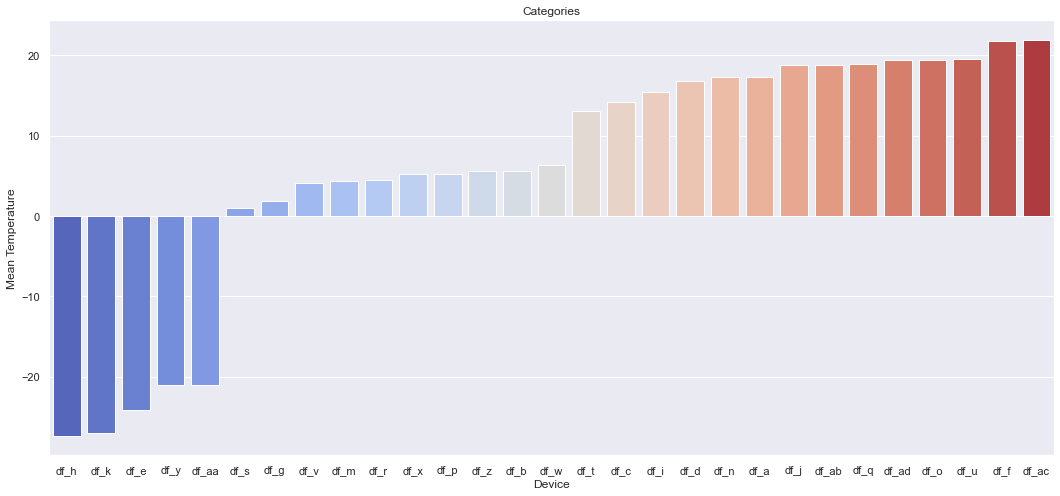

In [11]:
#sns.set_theme(style="whitegrid")
#sns.set_palette(sns.color_pallete("icefire"),as_cmap=True)
sns.set(rc={'figure.figsize':(18,8)})
sns.barplot(x="Device", 
            y="Mean Temperature", 
            data=mean_temp_dev,
            order=mean_temp_dev.sort_values('Mean Temperature').Device,
            palette = "coolwarm").set(title='Categories')
plt.show()

After plotting the dictionary we can easily see the average temperature for each dataframe and compare them to one another. This will help us with categorizing and labeling our dataframes.

## Categorizing Dataframes

After careful consideration and discussion we decided to seperate our dataframes into three distinct categories: Freezer, Fridge, Pantry

In [12]:
#barchart per category
#check the order
mean_temp_dev.sort_values(by='Mean Temperature',ascending=True).T

11     14     8     27     1     21    10    24    15  \
Device             df_h   df_k   df_e  df_y  df_aa  df_s  df_g  df_v  df_m   
Mean Temperature -27.33 -26.97 -24.13 -21.1  -21.0  0.96  1.91  4.14  4.37   

                    20  ...     16     0      13     2      19     4      17  \
Device            df_r  ...   df_n   df_a   df_j  df_ab   df_q  df_ad   df_o   
Mean Temperature  4.53  ...  17.24  17.33  18.83  18.83  18.89  19.41  19.43   

                     23     9      3   
Device             df_u   df_f  df_ac  
Mean Temperature  19.53  21.75  21.87  

[2 rows x 29 columns]

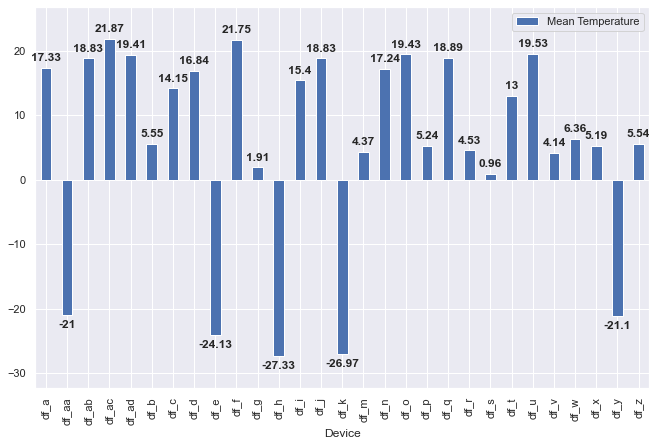

In [13]:
ax=mean_temp_dev.plot.bar(x='Device',
                   y='Mean Temperature',
                   figsize=(11,7))
#label for first visual
ax.bar_label(ax.containers[0], label_type='edge', fontweight='bold',padding=5)
ax.margins(y=0.1)

In [14]:
#categories
categories = []
customer_types = [
"",
"Food counter",
"",
"Medical facility",
"",
"Pharmacy",
"",
"Food production",
"Food production",
"Food counter",
"Food transport",
"Food production",
"",
"",
"Lab",
"Medical facility",
"",
"",
"Medical facility",
"Food production",
"Food counter",
"Food production",
"",
"",
"Medical facility",
"Pharmacy",
"Pharmacy",
"Lab",
"Pharmacy",
]

for value in mean_temp_dev['Mean Temperature']:
    if value < 0: 
        categories.append('Freezer')
    elif 0 <= value <= 8: 
        categories.append('Refrigerator')
    elif 14 <= value < 22:
        categories.append('Mapping')
    else: 
        categories.append('Unknown')

mean_temp_dev['Categories']  = categories
mean_temp_dev["Customer type"] = customer_types
mean_temp_dev.T

0             1        2                 3        4   \
Device               df_a         df_aa    df_ab             df_ac    df_ad   
Mean Temperature    17.33         -21.0    18.83             21.87    19.41   
Categories        Mapping       Freezer  Mapping           Mapping  Mapping   
Customer type              Food counter           Medical facility            

                            5        6                7                8   \
Device                    df_b     df_c             df_d             df_e   
Mean Temperature          5.55    14.15            16.84           -24.13   
Categories        Refrigerator  Mapping          Mapping          Freezer   
Customer type         Pharmacy           Food production  Food production   

                            9   ...               19            20  \
Device                    df_f  ...             df_q          df_r   
Mean Temperature         21.75  ...            18.89          4.53   
Categories             Mapping  ...          Mapping  Refrigerator   
Customer type     Food counter  ...  Food production  Food counter   

                               21       22       23                24  \
Device                       df_s     df_t     df_u              df_v   
Mean Temperature             0.96     13.0    19.53              4.14   
Categories           Refrigerator  Unknown  Mapping      Refrigerator   
Customer type     Food production                    Medical facility   

                            25            26       27            28  
Device                    df_w          df_x     df_y          df_z  
Mean Temperature          6.36          5.19    -21.1          5.54  
Categories        Refrigerator  Refrigerator  Freezer  Refrigerator  
Customer type         Pharmacy      Pharmacy      Lab      Pharmacy  

[4 rows x 29 columns]

In [15]:
mean_temp_dev['Categories'] = mean_temp_dev['Categories'].apply(lambda x: x.strip())

# Modify Categories based on Customer Type
for x in range(len(customer_types)):
    if mean_temp_dev['Categories'][x] == "Freezer":
        ## Code for Freezer
        pass
    elif mean_temp_dev['Categories'][x] == "Refrigerator":
        ## Code for fridge
        pass
    elif mean_temp_dev['Categories'][x] == "Mapping":
        ## Code for Mapping
        if mean_temp_dev['Customer type'][x] == "Medical facility":
            mean_temp_dev['Categories'][x] = "Incubator"
        elif mean_temp_dev['Customer type'][x] == "Food production":
            if mean_temp_dev['Mean Temperature'][x] > 17:
                mean_temp_dev['Categories'][x] = "Production area"
            else:
                mean_temp_dev['Categories'][x] = "Storage"
mean_temp_dev

WARNING - (py.warnings._showwarnmsg) - C:\Users\Daenir\AppData\Local\Temp/ipykernel_15924/2568472571.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_temp_dev['Categories'][x] = "Incubator"

WARNING - (py.warnings._showwarnmsg) - C:\Users\Daenir\AppData\Local\Temp/ipykernel_15924/2568472571.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_temp_dev['Categories'][x] = "Storage"

WARNING - (py.warnings._showwarnmsg) - C:\Users\Daenir\AppData\Local\Temp/ipykernel_15924/2568472571.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docum

Device  Mean Temperature       Categories     Customer type
0    df_a             17.33          Mapping                  
1   df_aa            -21.00          Freezer      Food counter
2   df_ab             18.83          Mapping                  
3   df_ac             21.87        Incubator  Medical facility
4   df_ad             19.41          Mapping                  
5    df_b              5.55     Refrigerator          Pharmacy
6    df_c             14.15          Mapping                  
7    df_d             16.84          Storage   Food production
8    df_e            -24.13          Freezer   Food production
9    df_f             21.75          Mapping      Food counter
10   df_g              1.91     Refrigerator    Food transport
11   df_h            -27.33          Freezer   Food production
12   df_i             15.40          Mapping                  
13   df_j             18.83          Mapping                  
14   df_k            -26.97          Freezer               Lab
15   df_m              4.37     Refrigerator  Medical facility
16   df_n             17.24          Mapping                  
17   df_o             19.43          Mapping                  
18   df_p              5.24     Refrigerator  Medical facility
19   df_q             18.89  Production area   Food production
20   df_r              4.53     Refrigerator      Food counter
21   df_s              0.96     Refrigerator   Food production
22   df_t             13.00          Unknown                  
23   df_u             19.53          Mapping                  
24   df_v              4.14     Refrigerator  Medical facility
25   df_w              6.36     Refrigerator          Pharmacy
26   df_x              5.19     Refrigerator          Pharmacy
27   df_y            -21.10          Freezer               Lab
28   df_z              5.54     Refrigerator          Pharmacy

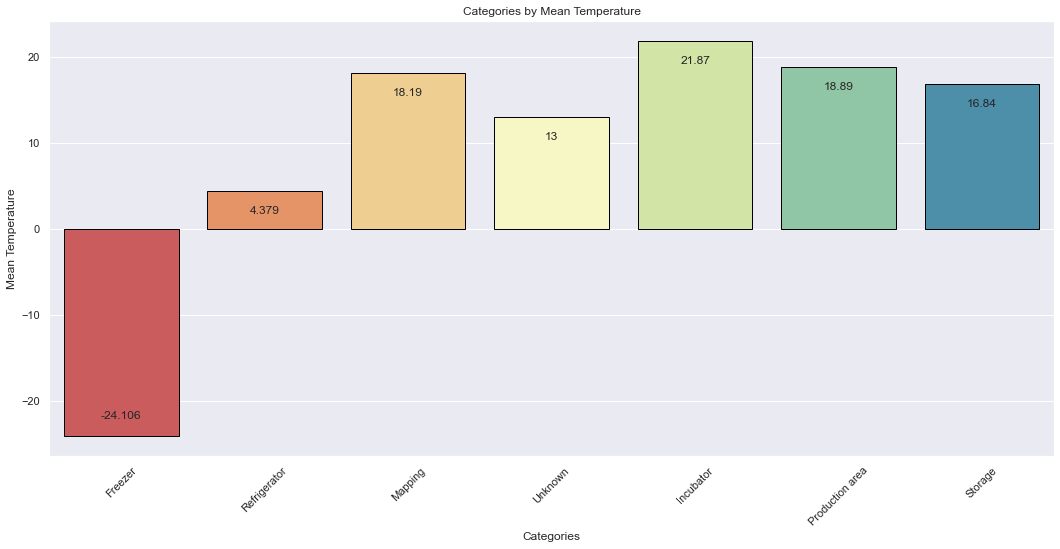

In [16]:
#barchart per group
plot = sns.barplot(data=mean_temp_dev,
                x="Categories",
                y="Mean Temperature",
                palette = "Spectral",
                ci=None,
                edgecolor="black",
                order=["Freezer", "Refrigerator","Mapping",'Unknown','Incubator',"Production area","Storage"])

plt.bar_label(plot.containers[0], label_type='edge',padding=-25)

plt.title('Categories by Mean Temperature')
plt.xticks(rotation=45)
plt.show()

As can be seen, each gadget was assigned to one of three groups:
- ``Freezer``: devices with temperature lower than 0.
- ``Refrigerator``: devices with temperature higher or equal than 0, but lower or equal than 8.
- ``Mapping``: devices with temperature higher or equal than 14, but lower than 22.
- ``Unknown``: devices with temperature outside the temperature range and we do not know for what it's being use.
- ``Incubator``: devices with the mapping temperature but use in the medical facility.
- ``Production Area``: devices with temperature higher than 17, but lower than 22 and use in food production.
- ``Storage``: devices with temperature higher or equal than 14, but lower than 17 and use in food production.

Because the data does not contain any labeling, such categorization is an obvious technique taken by group members through the usage of external resources.

Following the categorization of the devices, we want to observe each device's pattern through a line plot, which will allow us to approach any potential anomalies and subsequently approach the selection of view devices to make the research more comfortable.

WARNING - (py.warnings._showwarnmsg) - C:\Users\Daenir\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(



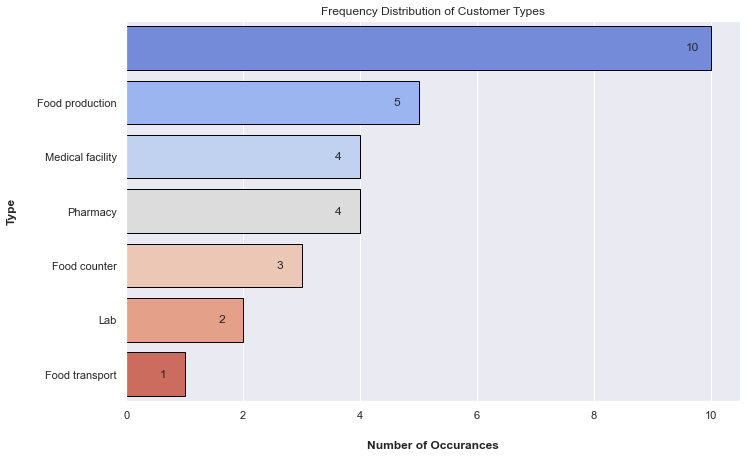

In [17]:
#barchart per customer type
#size
fig=plt.figure(figsize=(11,7))

#categorical distribution 
distribution = mean_temp_dev['Customer type'].value_counts()

#visual
plot = sns.barplot(distribution.values,
                   distribution.index,
                   palette = "coolwarm",
                   edgecolor="black")

plt.bar_label(plot.containers[0], label_type='edge',padding=-25)

#additionals
plt.title('Frequency Distribution of Customer Types')
plt.ylabel('Type',fontweight='bold',labelpad=20)
plt.xlabel('Number of Occurances',fontweight='bold',labelpad=20)
plt.show()


# Analysis of Elimination

Here we plot every dataframe divided based on category from which we will pick the most apropriate dataset to train our model on. In order for dataframe to be deemed apropriate for further analysis it needs to fufill the following conditions:
- Data Consistency
- None or very little missing values
- Upper and lower alarm threshold (Optional)

## Elimination of the First Category (Line Plots)

Elimination will be aided by a series of generic graphics, such as line plots to assess consistency, followed by box plots to identify missing values (outliers), and finally a final selection of a device per group.

### Freezer Category

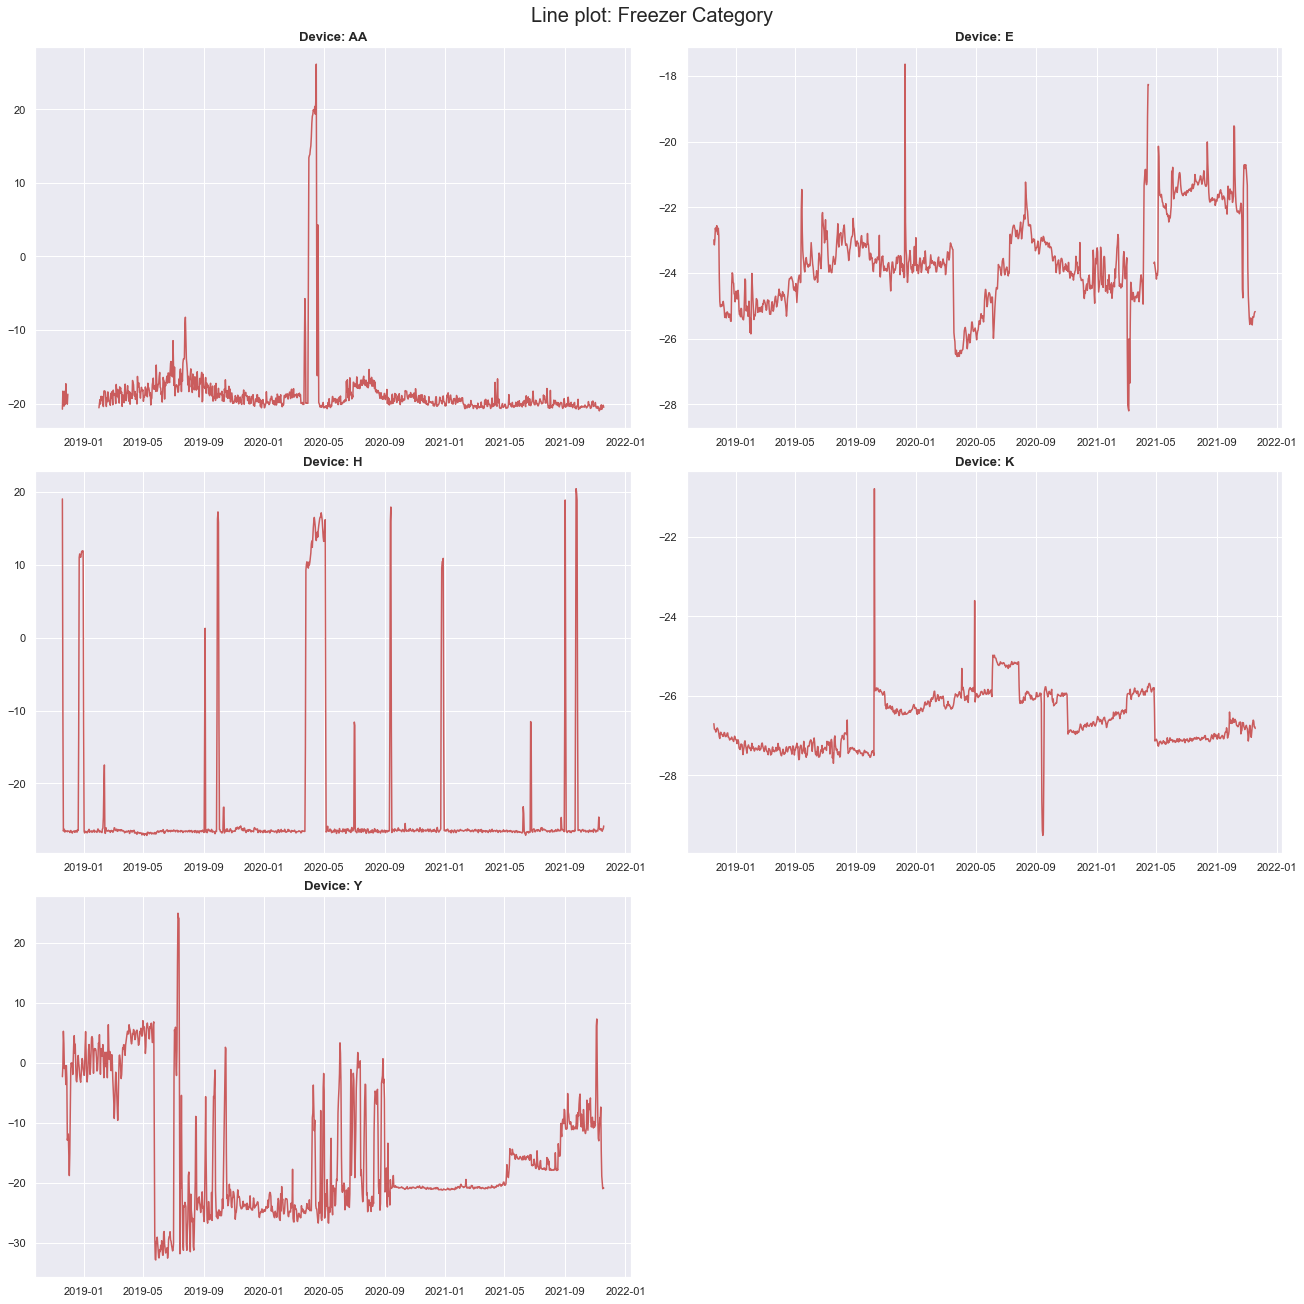

In [18]:
## AA, E, H, K, Y
# Height Margin
# plt.subplots_adjust(hspace=0.5)
fig, axes = plt.subplots(3,2, figsize=(18,18),constrained_layout=True)
fig.suptitle('Line plot: Freezer Category',fontsize=20)

datalist = ["df_aa_daily","df_e_daily","df_h_daily","df_k_daily","df_y_daily",]
titles = ['Device: AA','Device: E','Device: H','Device: K','Device: Y',]
i = -1
j = 0
for idx, (dataset,title) in enumerate(zip(datalist,titles)):
    ## Change Modulo to from 2 to 3 to make a 3-column plot
    if idx % 2 == 0:
        i = i + 1
        j = 0
    else: j = j + 1
    axes[i,j].plot(globals()['%s' % dataset]["Temp"],color='#ca5c5d')
    axes[i,j].set_title(title,fontweight='bold',fontsize=13)

#fig.suptitle('Fridge Category')

#remove useless axes
fig.delaxes(axes[2,1])
plt.draw()

As can be seen, there are 5 devices in the freezer category, all of which detect a small number of anomalies and appear to be consistent in their patterns; however, with so many devices, it will be difficult to approach an analysis for all of them; therefore, to limit our research, we will cut out E and Y devices due to their unprogized prattens that could complicate the modeling, and we will leave them out.

### Refrigerator Category

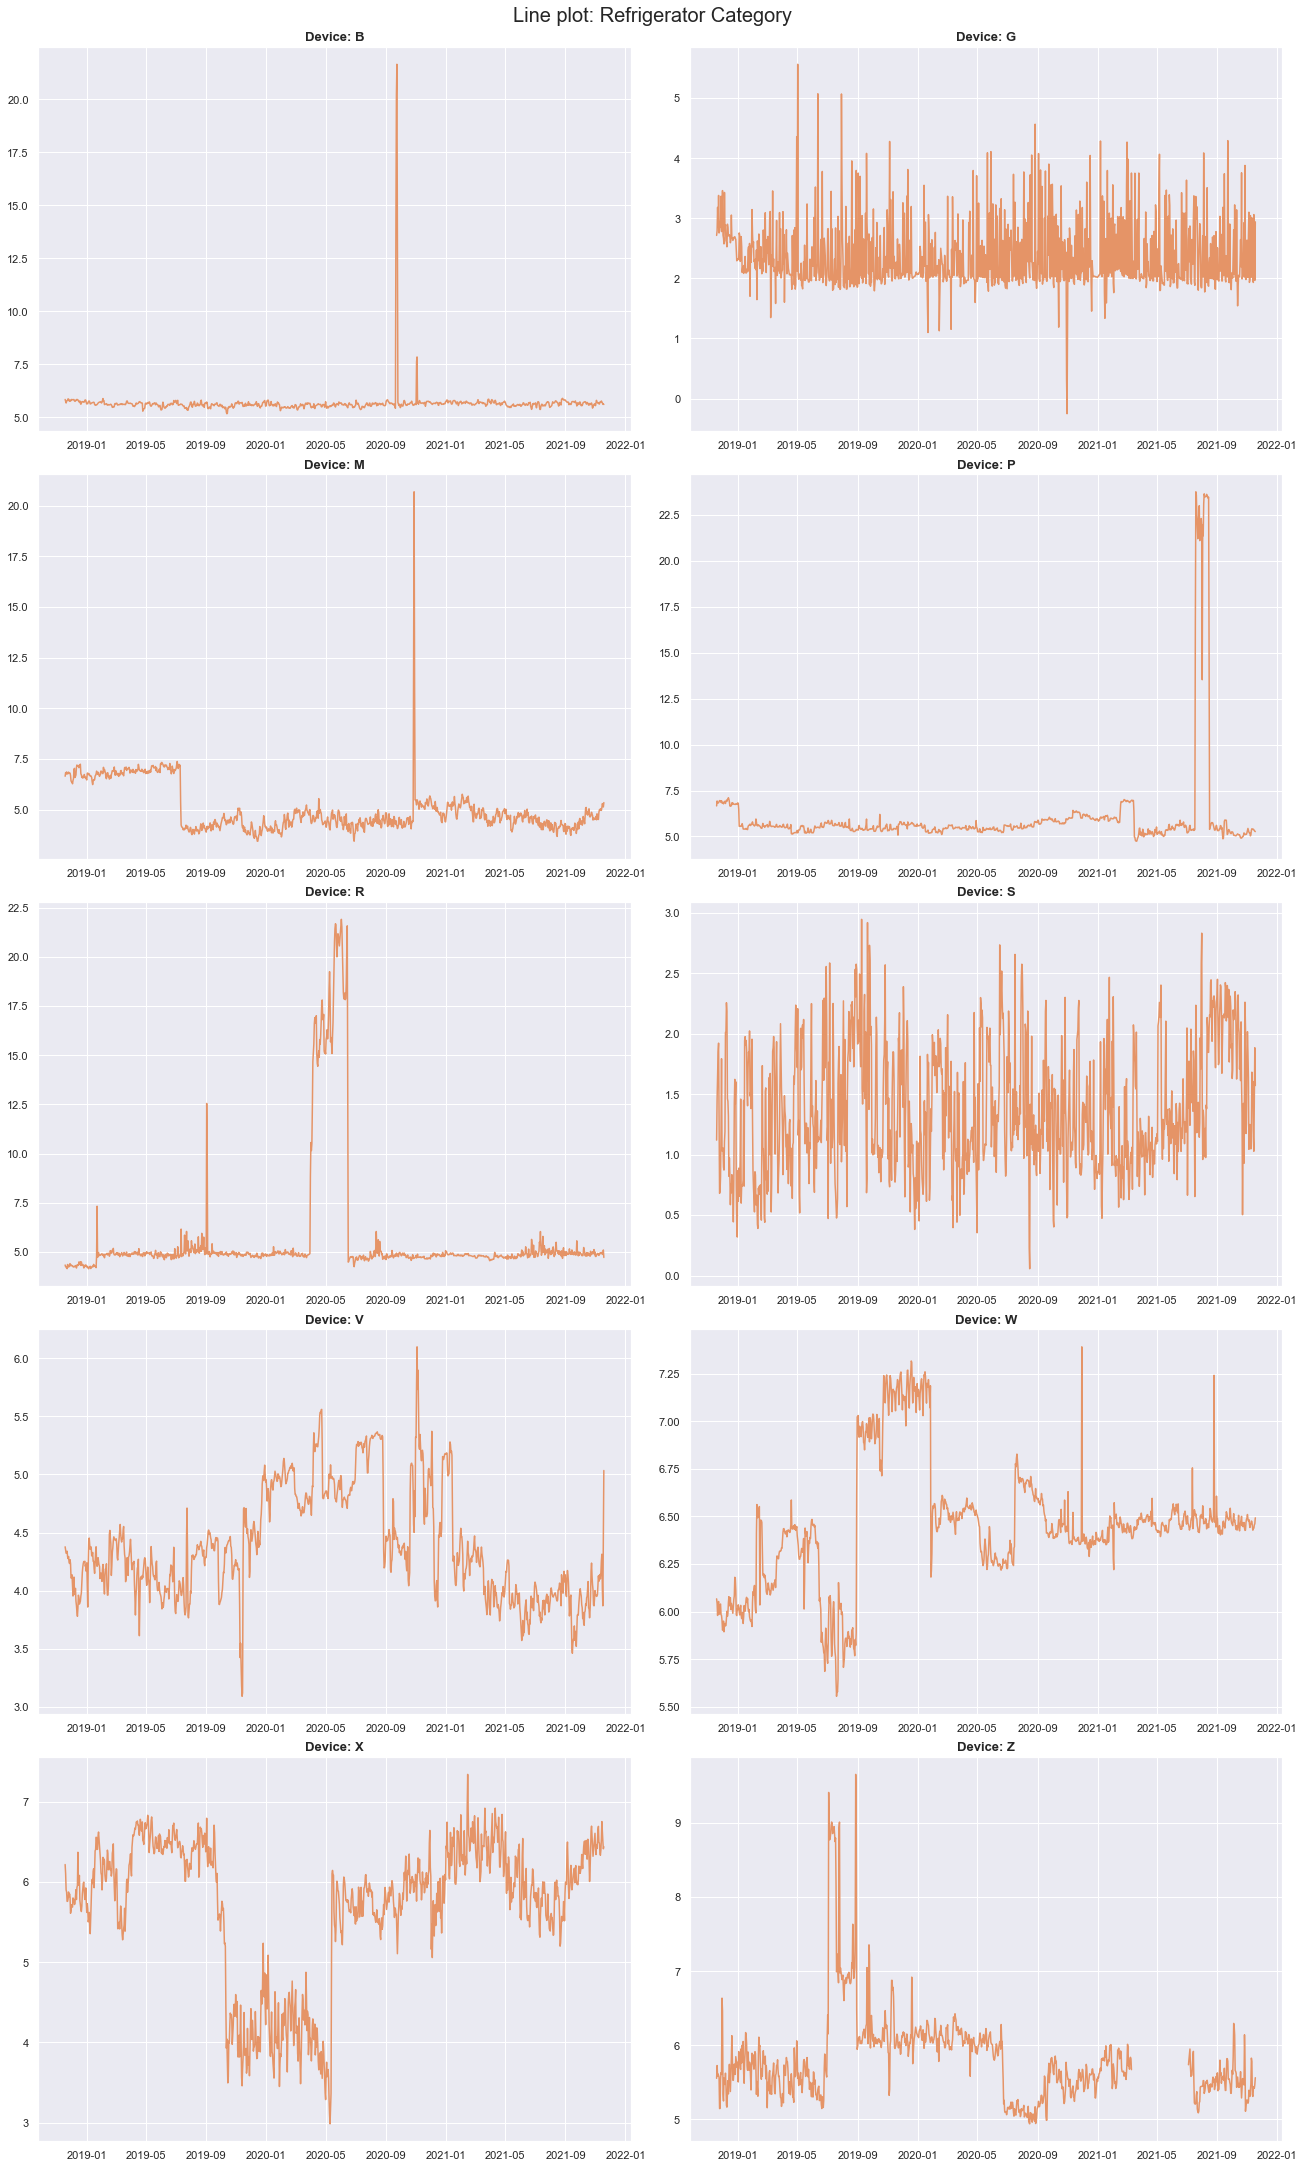

In [19]:
## B, G, M, P, R, S, V, W, X, Z
# Height Margin
# plt.subplots_adjust(hspace=0.5)
fig, axes = plt.subplots(5,2, figsize=(18,30),constrained_layout=True)
fig.suptitle('Line plot: Refrigerator Category',fontsize=20)

datalist = ["df_b_daily","df_g_daily","df_m_daily","df_p_daily","df_r_daily","df_s_daily","df_v_daily","df_w_daily","df_x_daily","df_z_daily"]
titles = ['Device: B','Device: G','Device: M','Device: P','Device: R','Device: S','Device: V','Device: W','Device: X','Device: Z']

i = -1
j = 0
for idx, (dataset,title) in enumerate(zip(datalist,titles)):
    ## Change Modulo to from 2 to 3 to make a 3-column plot
    if idx % 2 == 0:
        i = i + 1
        j = 0
    else: j = j + 1
    axes[i,j].plot(globals()['%s' % dataset]["Temp"],color='#e59467')
    axes[i,j].set_title(title,fontweight='bold',fontsize=13)
plt.show()

In comparison to the freezer, the fridge approached more devices on its scale and thus more possible dor analysis, but it also stayed above due to a complication of the amount provided, which could slow down the research and modeling. For future steps, we would like to stick with device B, S, and G because of their lack of anomalies and pattern consistency.

### Mapping Category

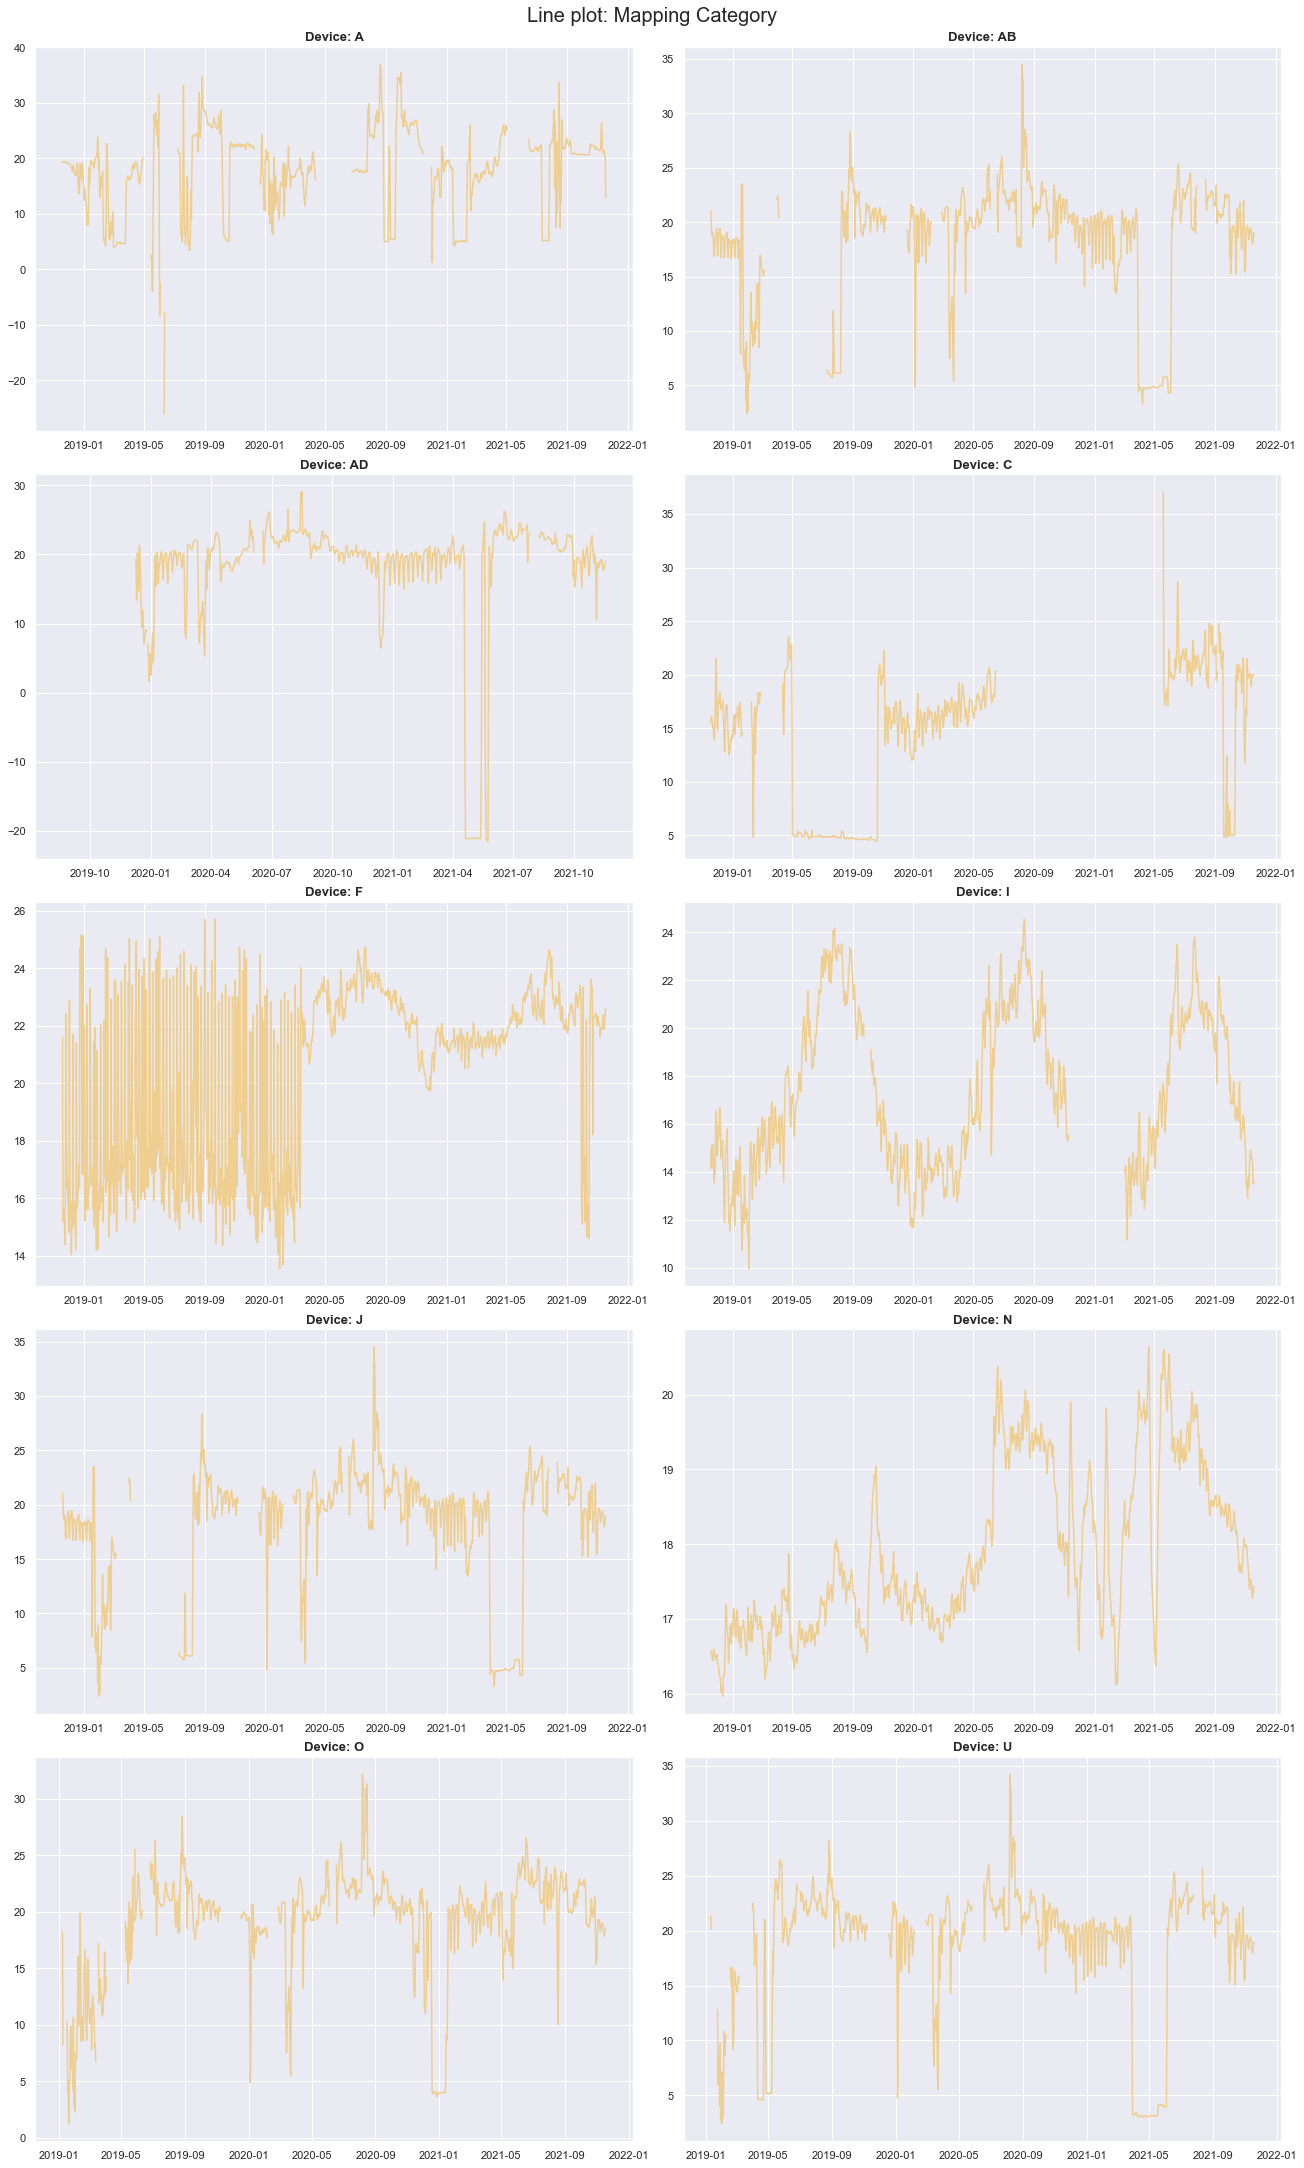

In [20]:
## A, AB, AD, C, F, I, J, N, O, U
#image
fig, axes = plt.subplots(5,2, figsize=(18,30),constrained_layout=True)
fig.suptitle('Line plot: Mapping Category',fontsize=20)

datalist = ["df_a_daily","df_ab_daily","df_ad_daily","df_c_daily","df_f_daily","df_i_daily","df_j_daily","df_n_daily","df_o_daily","df_u_daily",]
titles = ['Device: A','Device: AB','Device: AD','Device: C','Device: F','Device: I','Device: J','Device: N','Device: O','Device: U',]
i = -1
j = 0
for idx, (dataset,title) in enumerate(zip(datalist,titles)):
    ## Change Modulo to from 2 to 3 to make a 3-column plot
    if idx % 2 == 0:
        i = i + 1
        j = 0
    else: j = j + 1
    axes[i,j].plot(globals()['%s' % dataset]["Temp"],color='#eece91')
    axes[i,j].set_title(title,fontweight='bold',fontsize=13)

plt.show()

When it came to the pantry, it can be seen that the majority of the devices ended up in this group, which could be due to the scale range that we provided, but within a follow-up for the freezer and fridge, this part allowed us to see the pattern and provide additional limitations so that we could continue with our analysis phase.

### Rest of the categories: Incubator, Production Area and Storage 

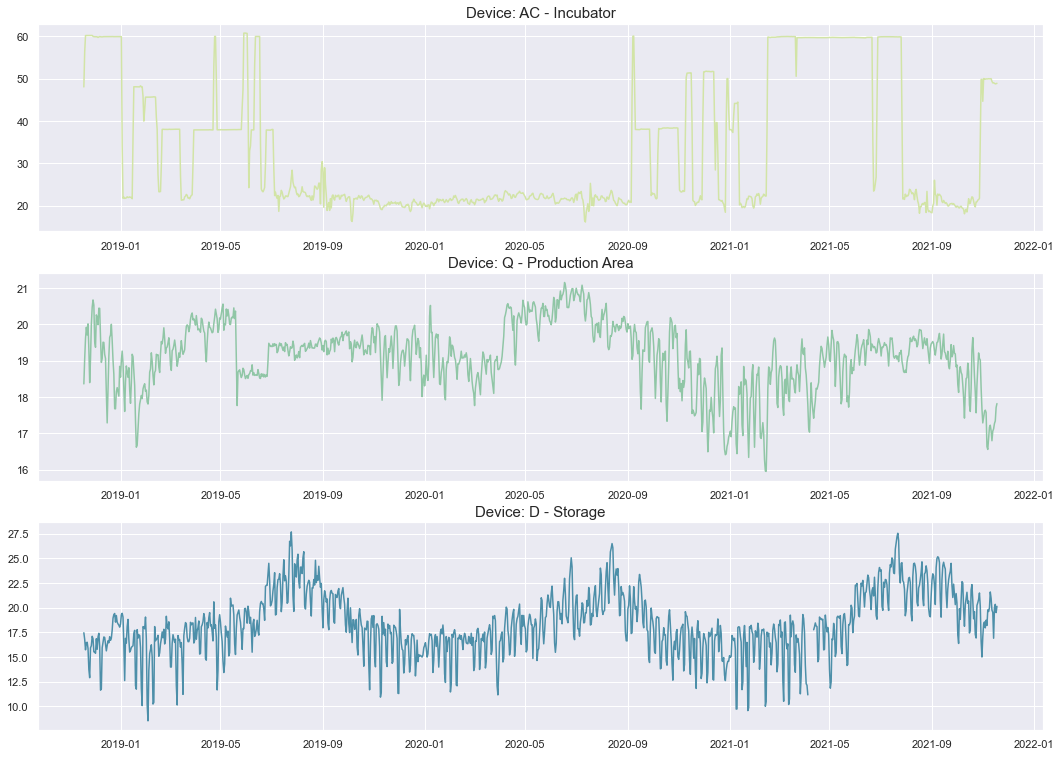

In [21]:

fig, axes = plt.subplots(3,1, figsize=(18,13))
axes[0].plot(df_ac_daily["Temp"],color='#d2e4a6')
axes[1].plot(df_q_daily["Temp"],color='#90c6a6')
axes[2].plot(df_d_daily["Temp"],color='#4d8fa9')

axes[0].set_title('Device: AC - Incubator', fontsize=15)
axes[1].set_title('Device: Q - Production Area', fontsize=15)
axes[2].set_title('Device: D - Storage', fontsize=15)

plt.show()

## Elimination of the Second Category (Box Plots)

After manually picking three datasets from each category we are ready to explore them and pick one for each category

### Freezers

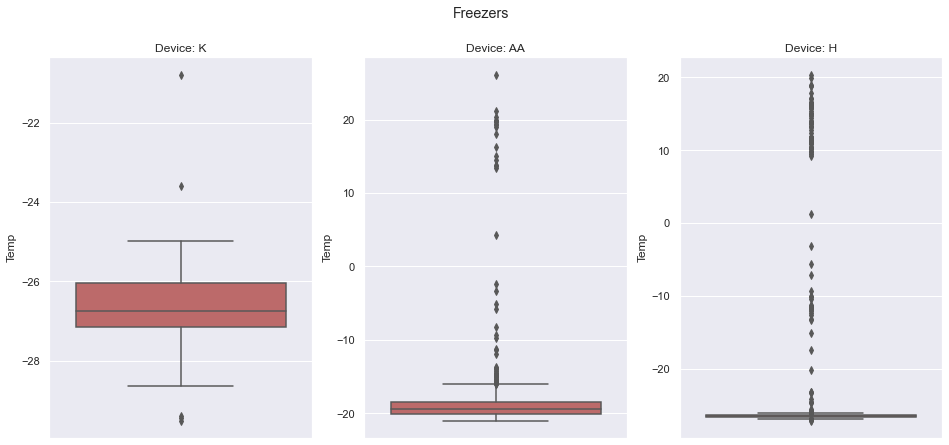

In [22]:
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('Freezers')
sns.boxplot(ax=axes[0],y="Temp",data=df_k_daily,color='#ca5c5d')
sns.boxplot(ax=axes[1],y="Temp",data=df_aa_daily,color='#ca5c5d')
sns.boxplot(ax=axes[2],y="Temp",data=df_h_daily,color='#ca5c5d')
axes[0].set_title('Device: K')
axes[1].set_title('Device: AA')
axes[2].set_title('Device: H')
plt.show()

Based on the results, we will choose **device K** since it has less outliers than devices AA and H, which can be easily spotted within a large number of them, slowing down our research and harming further modeling. As a consequence, we will continue to use device K for future study.

### Refrigerators

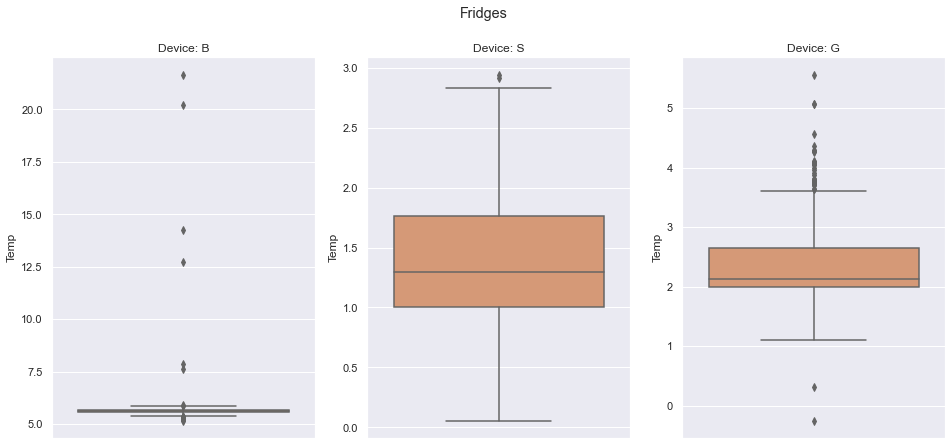

In [23]:
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('Fridges')
sns.boxplot(ax=axes[0],y="Temp",data=df_b_daily,color='#e59467')
sns.boxplot(ax=axes[1],y="Temp",data=df_s_daily,color='#e59467')
sns.boxplot(ax=axes[2],y="Temp",data=df_g_daily,color='#e59467')
axes[0].set_title('Device: B')
axes[1].set_title('Device: S')
axes[2].set_title('Device: G')
plt.show()

In the case of the refrigerator, it is clear that **device B** will be eliminated due to its outliers, and that device G will be eliminated due to the outliers accumulating in the scale from 5 to 4 degrees. As a result, we will stick with device S, even though it contributed to a few of the outliers, because it is more useful for further research and modeling than the other two.

### Mappings

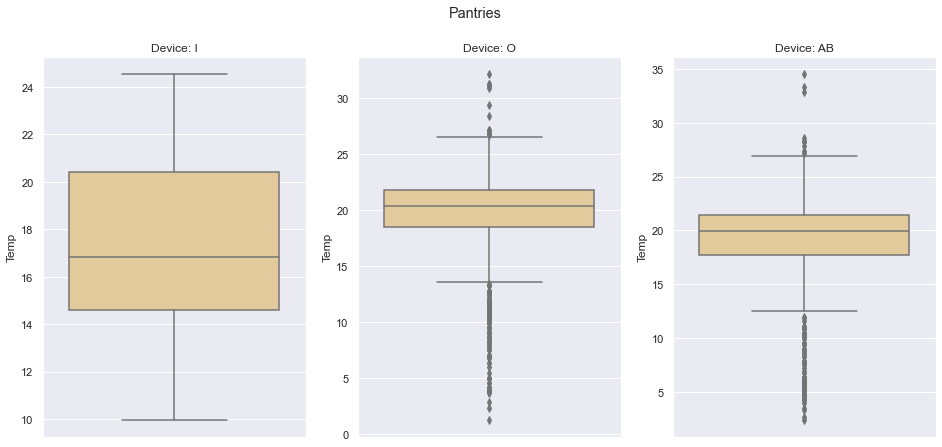

In [24]:
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('Pantries')
sns.boxplot(ax=axes[0],y="Temp",data=df_i_daily,color='#eece91')
sns.boxplot(ax=axes[1],y="Temp",data=df_o_daily,color='#eece91')
sns.boxplot(ax=axes[2],y="Temp",data=df_ab_daily,color='#eece91')
axes[0].set_title('Device: I')
axes[1].set_title('Device: O')
axes[2].set_title('Device: AB')
plt.show()

Following the same pattern as before, we will stick to **device I** as our main research recognition for the pantry category, based on the outliers in device D and AB. This is done with the idea that trained models with outliers will increase error variance and reduce the power of statistical tests for our modeling, so we approached to be sticking with device I.

### Rest of the categories: Incubator, Production Area and Storage

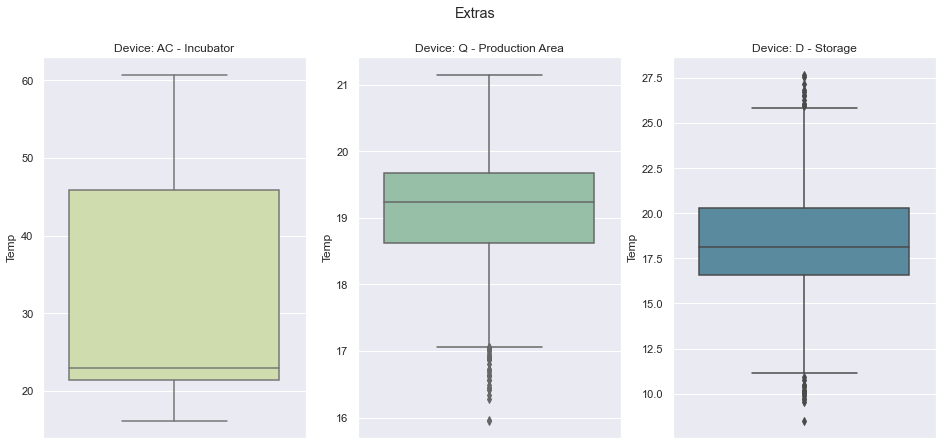

In [25]:
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('Extras')
sns.boxplot(ax=axes[0],y="Temp",data=df_ac_daily,color='#d2e4a6')
sns.boxplot(ax=axes[1],y="Temp",data=df_q_daily,color='#90c6a6')
sns.boxplot(ax=axes[2],y="Temp",data=df_d_daily,color='#4d8fa9')

axes[0].set_title('Device: AC - Incubator')
axes[1].set_title('Device: Q - Production Area')
axes[2].set_title('Device: D - Storage')

plt.show()

## Conclusion

Based on the analysis that we've done, we decide to use **Device K** for the freezer, **Device S** for the Refrigerator, **Device I** for the mapping, and lastly **Device D** for extra.

# Analysis for Device K (Freezer)

## The Outliers and Overviews

From the plot below, we can see that on the first plot is showing the outliers from device K in each month, the second plot is showing the overview for the entire week, and lastly the third plot is showing us the overview for the whole day (24 Hours).

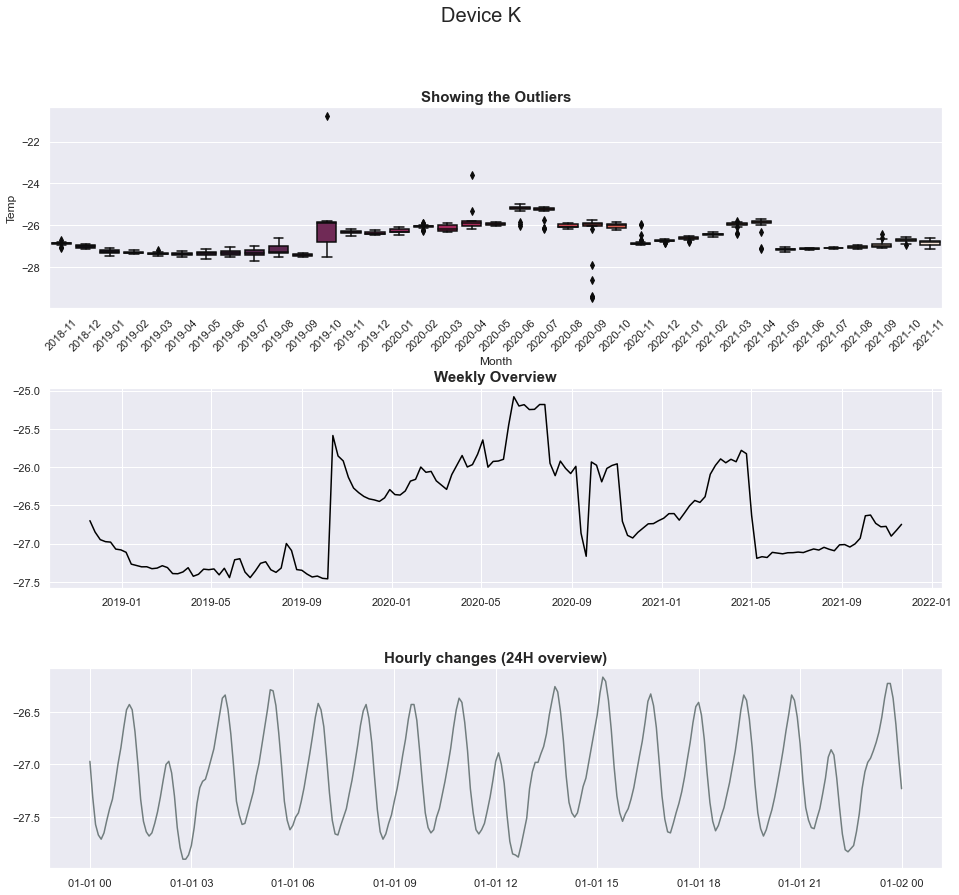

In [26]:
df_k_copy = df_k_daily.copy()
df_k_copy["Month"] = df_k_copy.index.to_period('M')

df_k_zoom = df_k.loc["2019-01-01 00:00:00":"2019-01-02 00:00:00"]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16,14))
plt.subplots_adjust(hspace=0.4)
sns.boxplot(ax=axes[0],x="Month",y="Temp",data=df_k_copy,palette = "rocket")
fig.suptitle('Device K',fontsize=20)
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 45)
axes[1].plot(df_k_weekly,color='black' )
axes[2].plot(df_k_zoom,color='#717D7E')
axes[0].set_title('Showing the Outliers', fontsize=15,fontweight='bold')
axes[1].set_title('Weekly Overview', fontsize=15,fontweight='bold')
axes[2].set_title('Hourly changes (24H overview)', fontsize=15,fontweight='bold')

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)  
plt.show()

## The Null Values in the Dataset of Device K
Here we can see that Device K has 59 null values out of 315.648 values.

In [27]:
df_k.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315648 entries, 2018-11-18 16:40:00 to 2021-11-18 16:35:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Temp    315589 non-null  float64
dtypes: float64(1)
memory usage: 12.9 MB


In [28]:
df_k.isna().sum()

Temp    59
dtype: int64

## The Upper Limit and Lower Limit of Device K
As we can see from the plot below that the upper limit from Device K is -20 degrees and the lower limit is below -20 degrees.

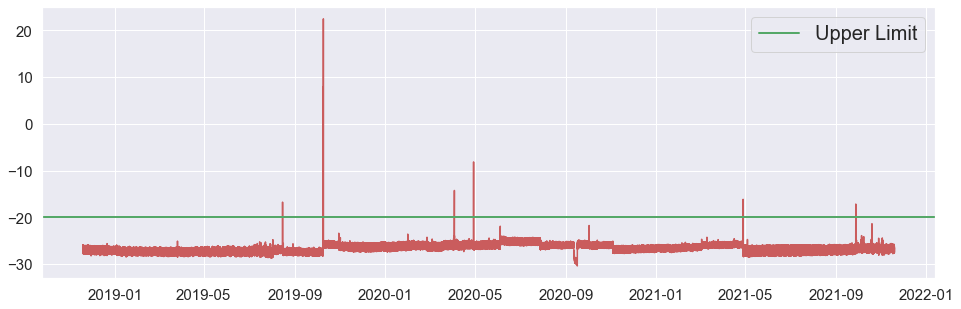

In [29]:
fig, axes = plt.subplots(1,1, figsize=(16,5))
plt.plot(df_k, color='#ca5c5d')
plt.axhline(y=-20,color='g',linestyle='-',label='Upper Limit',linewidth=2)

plt.legend(prop={'size': 20})

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

plt.show()

## Seasonal Decomposition of Device K
From the plot below we can see the actual dataset, we can the trend of the data, we can see if there's seasonality in the data, and lastly we can see if there's any residual in our data.

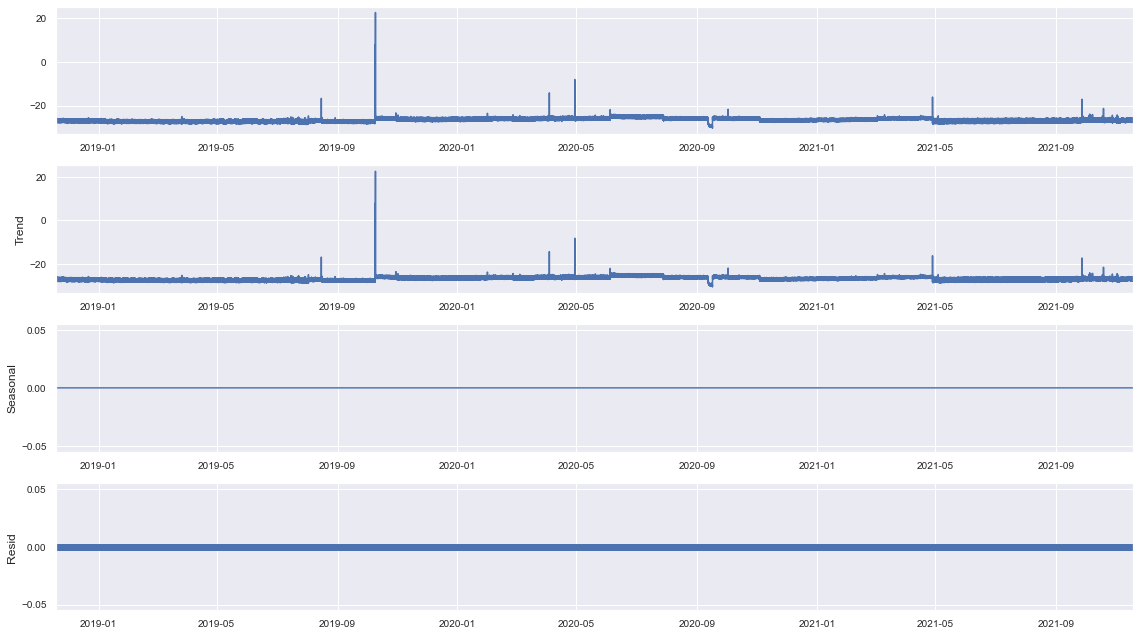

In [30]:
result = seasonal_decompose(df_k.dropna(), model='additive', period=1)
fig = result.plot()
fig.set_size_inches((16, 9))

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
# Tight layout to realign things
fig.tight_layout()
plt.show()

##  Classifying the Temperature Stages

In [10]:
df_k_copy = df_k.dropna()
df_k_copy

Temp
EventDt                   
2018-11-18 16:40:00 -25.93
2018-11-18 16:45:00 -26.14
2018-11-18 16:50:00 -26.44
2018-11-18 16:55:00 -26.80
2018-11-18 17:00:00 -27.04
...                    ...
2021-11-18 16:15:00 -26.95
2021-11-18 16:20:00 -26.76
2021-11-18 16:25:00 -26.54
2021-11-18 16:30:00 -26.54
2021-11-18 16:35:00 -26.77

[315589 rows x 1 columns]

In [11]:
# Z score
z = np.abs(stats.zscore(df_k_copy['Temp']))
print(z)

EventDt
2018-11-18 16:40:00    0.748278
2018-11-18 16:45:00    0.523413
2018-11-18 16:50:00    0.202178
2018-11-18 16:55:00    0.183305
2018-11-18 17:00:00    0.440293
                         ...   
2021-11-18 16:15:00    0.343922
2021-11-18 16:20:00    0.140473
2021-11-18 16:25:00    0.095099
2021-11-18 16:30:00    0.095099
2021-11-18 16:35:00    0.151181
Name: Temp, Length: 315589, dtype: float64


In [32]:
threshold =3

indexes = np.where(z > threshold)
 
# Position of the outlier
print(indexes)

(array([ 77678,  77679,  77680,  77681,  77682,  77683,  77684,  77685,
        77686,  77687,  77688,  77689,  77690,  93455,  93456,  93457,
        93458,  93459,  93460,  93461,  93462,  93463,  93464,  93465,
        93466,  93467,  93468,  93469,  93470,  93471,  93472,  93473,
        93474,  93475,  93476,  93477,  93478,  93479,  93480,  93481,
        93482,  93483,  93484,  93485,  93517,  93518,  93519,  93520,
        93521,  93522,  93523,  93524,  93525,  93526,  93527,  93528,
        93529,  93530,  93531,  93532,  93533,  93534,  93535,  93536,
        93537,  93538,  93539,  93540,  93541,  93542,  93543,  93544,
        93545,  93546,  93547,  93548,  93549,  93550,  93551,  93552,
        93553,  93554,  99537,  99538,  99539,  99540, 126350, 126351,
       126352, 144478, 144479, 144480, 144481, 144482, 144483, 144484,
       144485, 144486, 144487, 144488, 144489, 144490, 144491, 144492,
       144493, 144494, 144495, 144496, 144497, 144498, 144499, 144500,
     

In [33]:
df_k_copy.drop(df_k_copy.index[indexes],axis=0,inplace=True)
df_k_copy

WARNING - (py.warnings._showwarnmsg) - C:\Users\shane\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(



Temp
EventDt                   
2018-11-18 16:40:00 -25.93
2018-11-18 16:45:00 -26.14
2018-11-18 16:50:00 -26.44
2018-11-18 16:55:00 -26.80
2018-11-18 17:00:00 -27.04
...                    ...
2021-11-18 16:15:00 -26.95
2021-11-18 16:20:00 -26.76
2021-11-18 16:25:00 -26.54
2021-11-18 16:30:00 -26.54
2021-11-18 16:35:00 -26.77

[312705 rows x 1 columns]

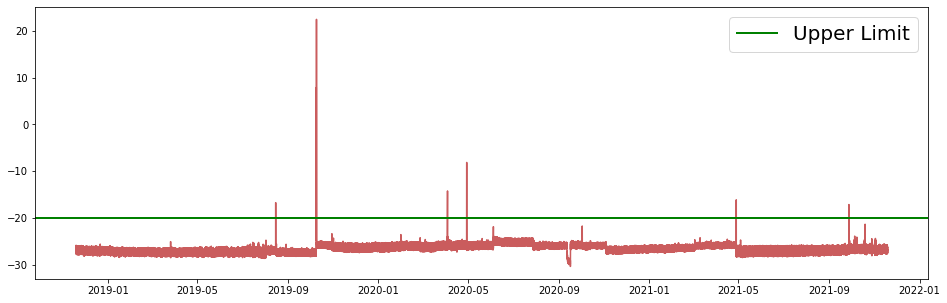

In [34]:
fig, axes = plt.subplots(1,1, figsize=(16,5))
plt.plot(df_k, color='#ca5c5d')
plt.axhline(y=-20,color='g',linestyle='-',label='Upper Limit',linewidth=2)

plt.legend(prop={'size': 20})

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

plt.show()

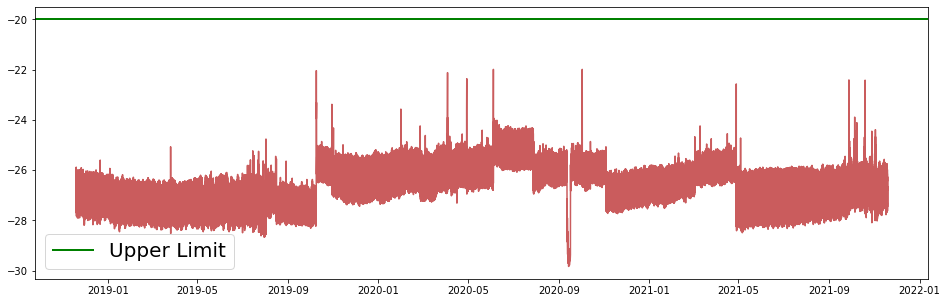

In [35]:
fig, axes = plt.subplots(1,1, figsize=(16,5))
plt.plot(df_k_copy, color='#ca5c5d')
plt.axhline(y=-20,color='g',linestyle='-',label='Upper Limit',linewidth=2)

plt.legend(prop={'size': 20})

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

plt.show()

# Analysis for Device S (Refrigerators)

## Missing Data

In [37]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315647 entries, 2018-11-18 16:50:00 to 2021-11-18 16:40:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Temp    315640 non-null  float64
dtypes: float64(1)
memory usage: 12.9 MB


In [38]:
df_s.isna().sum()

Temp    7
dtype: int64

As can be seen on this analysis, *device S* contains up to 7 missng values, which is much lower compare to the previous device and a total of 315.648.

## Outliers and Seasonality Overview

From the plot below, we can see that on the first plot is showing the outliers from device S in each month, the second plot is showing the overview for the entire week, and lastly the third plot is showing us the overview for the whole day (24 Hours).

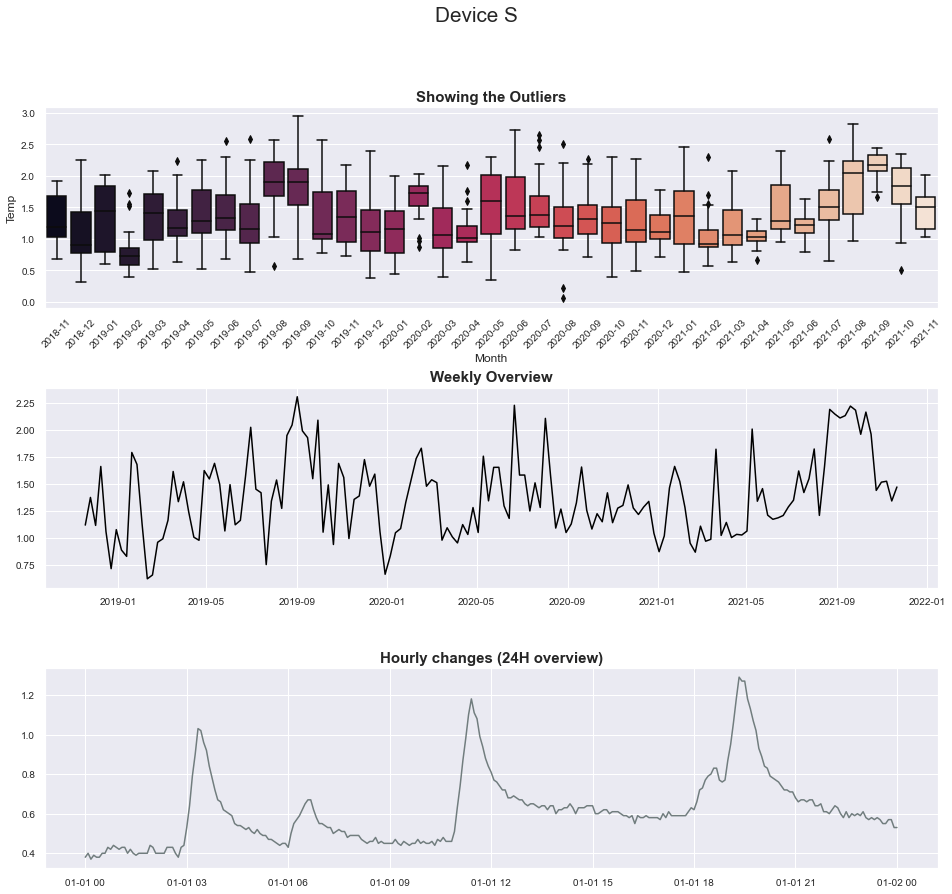

In [39]:
df_s_copy = df_s_daily.copy()
df_s_copy["Month"] = df_s_copy.index.to_period('M')

df_s_zoom = df_s.loc["2019-01-01 00:00:00":"2019-01-02 00:00:00"]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16,14))
plt.subplots_adjust(hspace=0.4)
sns.boxplot(ax=axes[0],x="Month",y="Temp",data=df_s_copy,palette = "rocket")
fig.suptitle('Device S',fontsize="xx-large")
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 45)
axes[1].plot(df_s_weekly,color='black' )
axes[2].plot(df_s_zoom,color='#717D7E')
axes[0].set_title('Showing the Outliers', fontsize=15,fontweight='bold')
axes[1].set_title('Weekly Overview', fontsize=15,fontweight='bold')
axes[2].set_title('Hourly changes (24H overview)', fontsize=15,fontweight='bold')

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)  
plt.show()

## Upper and Lower Limits

Upper and lower limits are taken from another dataset; for example, for device S, the upper limit is 25 and the bottom limit is 8; to show this, as well as the device's consistency through time, see the visual below.

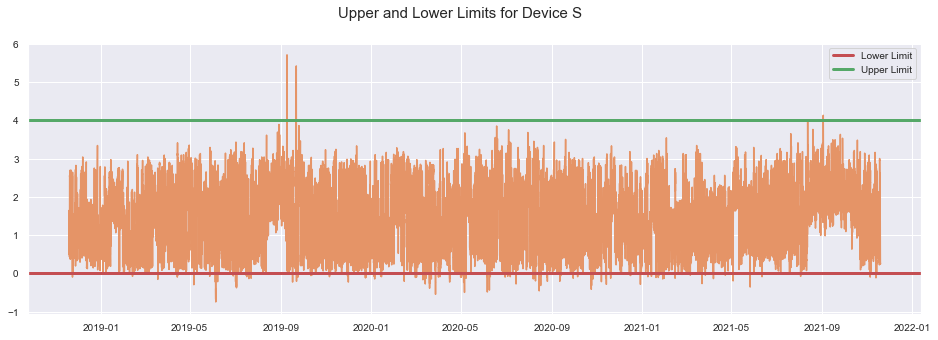

In [40]:
fig, axes = plt.subplots(1,1, figsize=(16,5))
fig.suptitle('Upper and Lower Limits for Device S',fontsize=15)
plt.plot(df_s,color="#e59467")
plt.axhline(y=0,color='r',linestyle='-',label='Lower Limit',linewidth=3) #taken from another dataset
plt.axhline(y=4,color='g',linestyle='-',label='Upper Limit',linewidth=3)

plt.legend(prop={'size': 10})

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

plt.show()

## Seasonal Decomposition

From the plot below we can see the actual dataset, we can the trend of the data, we can see if there's seasonality in the data, and lastly we can see if there's any residual in our data.

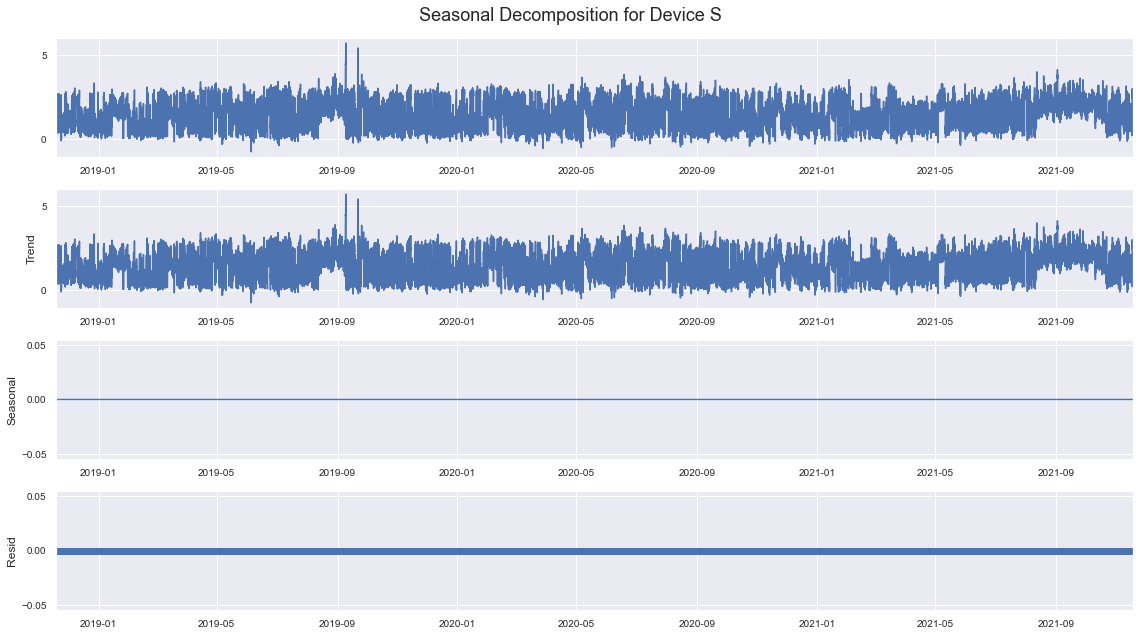

In [41]:
result = seasonal_decompose(df_s.dropna(), model='additive', period=1)
fig = result.plot()
fig.suptitle('Seasonal Decomposition for Device S',fontsize=18)
fig.set_size_inches((16, 9))

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

#extra
fig.tight_layout()
plt.show()

## Classifying

In [51]:
df_s_copy = df_s.dropna()
df_s_copy = df_s_copy.resample('H').sum()
df_s_copy

Temp
EventDt                   
2018-11-18 16:00:00   2.47
2018-11-18 17:00:00  13.70
2018-11-18 18:00:00  13.84
2018-11-18 19:00:00  17.38
2018-11-18 20:00:00  13.92
...                    ...
2021-11-18 12:00:00  10.58
2021-11-18 13:00:00   9.45
2021-11-18 14:00:00   6.82
2021-11-18 15:00:00   5.12
2021-11-18 16:00:00   2.66

[26305 rows x 1 columns]

In [52]:
outliers = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clusters = outliers.fit_predict(df_s_copy)
df_s_copy['Cluster'] = clusters
df_s_copy

Temp  Cluster
EventDt                            
2018-11-18 16:00:00   2.47        0
2018-11-18 17:00:00  13.70        0
2018-11-18 18:00:00  13.84        0
2018-11-18 19:00:00  17.38        0
2018-11-18 20:00:00  13.92        0
...                    ...      ...
2021-11-18 12:00:00  10.58        0
2021-11-18 13:00:00   9.45        0
2021-11-18 14:00:00   6.82        0
2021-11-18 15:00:00   5.12        0
2021-11-18 16:00:00   2.66        0

[26305 rows x 2 columns]

In [53]:
df_s_copy['ClusterName'] = df_s_copy['Cluster'].map({0: "Normal data", -1: "Outlier"})
df_s_copy

Temp  Cluster  ClusterName
EventDt                                         
2018-11-18 16:00:00   2.47        0  Normal data
2018-11-18 17:00:00  13.70        0  Normal data
2018-11-18 18:00:00  13.84        0  Normal data
2018-11-18 19:00:00  17.38        0  Normal data
2018-11-18 20:00:00  13.92        0  Normal data
...                    ...      ...          ...
2021-11-18 12:00:00  10.58        0  Normal data
2021-11-18 13:00:00   9.45        0  Normal data
2021-11-18 14:00:00   6.82        0  Normal data
2021-11-18 15:00:00   5.12        0  Normal data
2021-11-18 16:00:00   2.66        0  Normal data

[26305 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

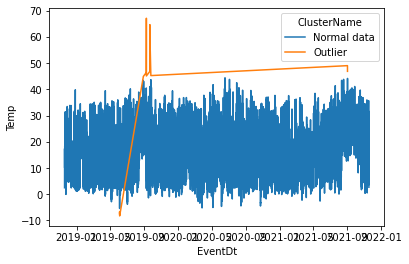

In [54]:
sns.lineplot(data= df_s_copy, x= df_s_copy.index, y='Temp', hue = 'ClusterName')

In [55]:
df_s_copy

Temp  Cluster  ClusterName
EventDt                                         
2018-11-18 16:00:00   2.47        0  Normal data
2018-11-18 17:00:00  13.70        0  Normal data
2018-11-18 18:00:00  13.84        0  Normal data
2018-11-18 19:00:00  17.38        0  Normal data
2018-11-18 20:00:00  13.92        0  Normal data
...                    ...      ...          ...
2021-11-18 12:00:00  10.58        0  Normal data
2021-11-18 13:00:00   9.45        0  Normal data
2021-11-18 14:00:00   6.82        0  Normal data
2021-11-18 15:00:00   5.12        0  Normal data
2021-11-18 16:00:00   2.66        0  Normal data

[26305 rows x 3 columns]

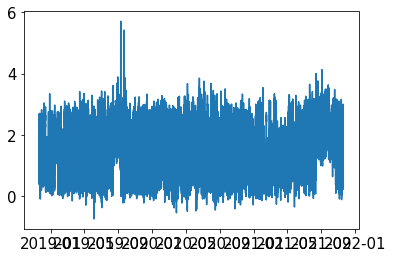

In [58]:
plt.plot(df_s)

# Analysis for Device I (Mapping)
## The Outliers and Overviews
From the plot below, we can see that on the first plot is showing the outliers from device I in each month, the second plot is showing the overview for the entire week, and lastly the third plot is showing us the overview for the whole day (24 Hours).

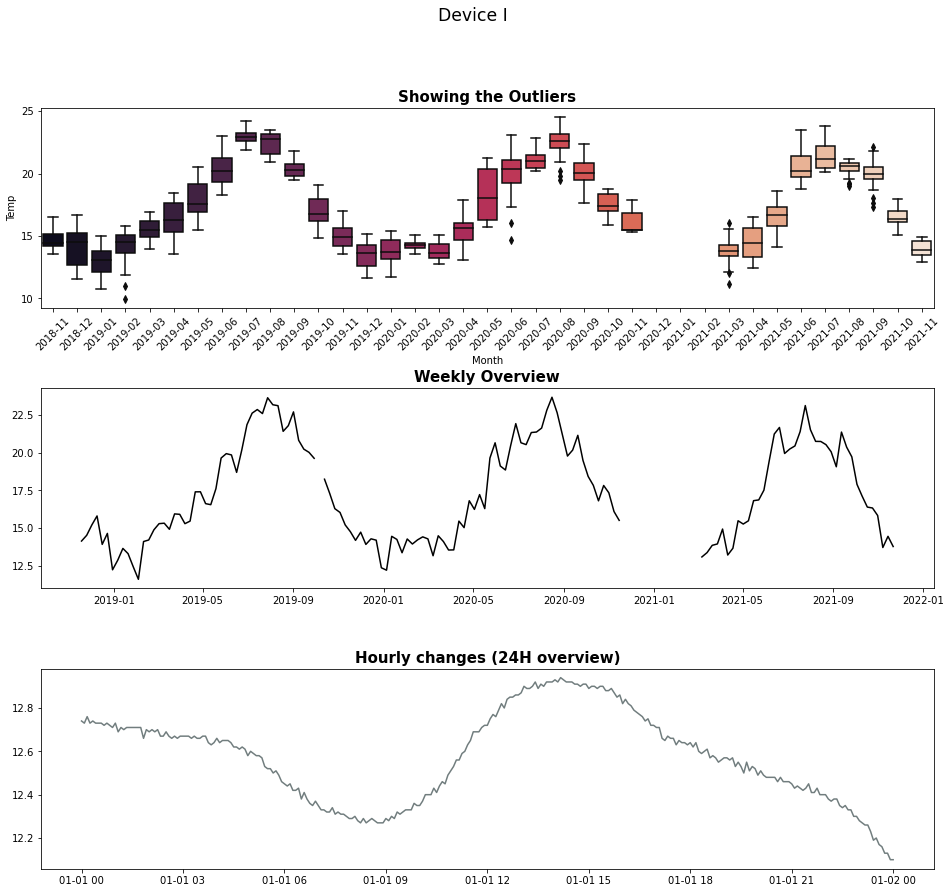

In [57]:
df_i_copy = df_i_daily.copy()
df_i_copy["Month"] = df_i_copy.index.to_period('M')

df_i_zoom = df_i.loc["2019-01-01 00:00:00":"2019-01-02 00:00:00"]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16,14))
plt.subplots_adjust(hspace=0.4)
sns.boxplot(ax=axes[0],x="Month",y="Temp",data=df_i_copy,palette = "rocket")
fig.suptitle('Device I',fontsize="xx-large")
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 45)
axes[1].plot(df_i_weekly,color='black' )
axes[2].plot(df_i_zoom,color='#717D7E')
axes[0].set_title('Showing the Outliers', fontsize=15,fontweight='bold')
axes[1].set_title('Weekly Overview', fontsize=15,fontweight='bold')
axes[2].set_title('Hourly changes (24H overview)', fontsize=15,fontweight='bold')

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.show()

## The Null Values in the Dataset of Device I
Here we can see that Device K has 59 null values out of 315.648 values.

In [46]:
df_i.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315648 entries, 2018-11-18 16:35:00 to 2021-11-18 16:30:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Temp    278713 non-null  float64
dtypes: float64(1)
memory usage: 12.9 MB


In [47]:
df_i.isna().sum()

Temp    36935
dtype: int64

In [48]:
#df_i.rename(columns = {'y':'Temp'}, inplace = True)

<AxesSubplot:ylabel='EventDt'>

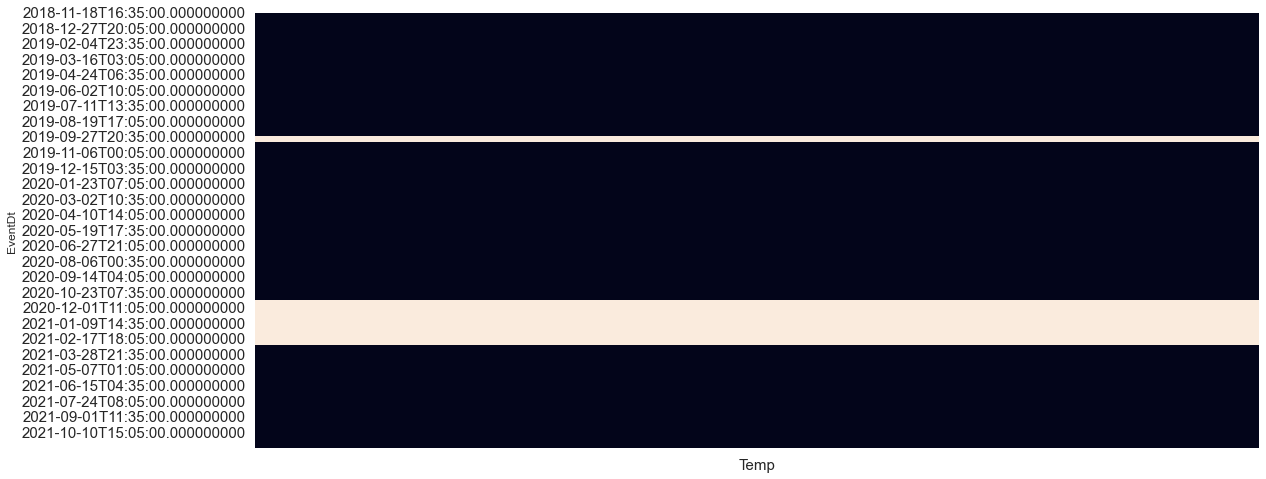

In [49]:
sns.heatmap(df_i.isnull(), cbar=False)

## The Upper Limit and Lower Limit of Device I
As we can see from the plot below that the upper limit from Device I is 25 degrees and the lower limit from Device I is 8 degrees.

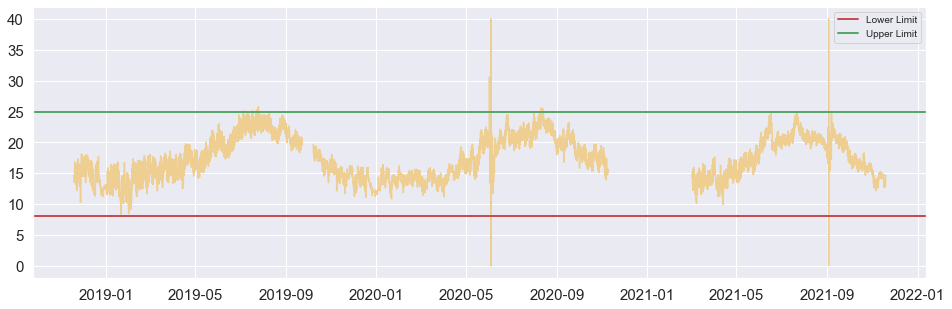

In [50]:
fig, axes = plt.subplots(1,1, figsize=(16,5))
plt.plot(df_i, color='#eece91')
plt.axhline(y=8,color='r',linestyle='-',label='Lower Limit',linewidth=2)
plt.axhline(y=25,color='g',linestyle='-',label='Upper Limit',linewidth=2)

plt.legend(prop={'size': 10})

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

plt.show()

## Seasonal Decomposition of Device I
From the plot below we can see the actual dataset, we can the trend of the data, we can see if there's seasonality in the data, and lastly we can see if there's any residual in our data.

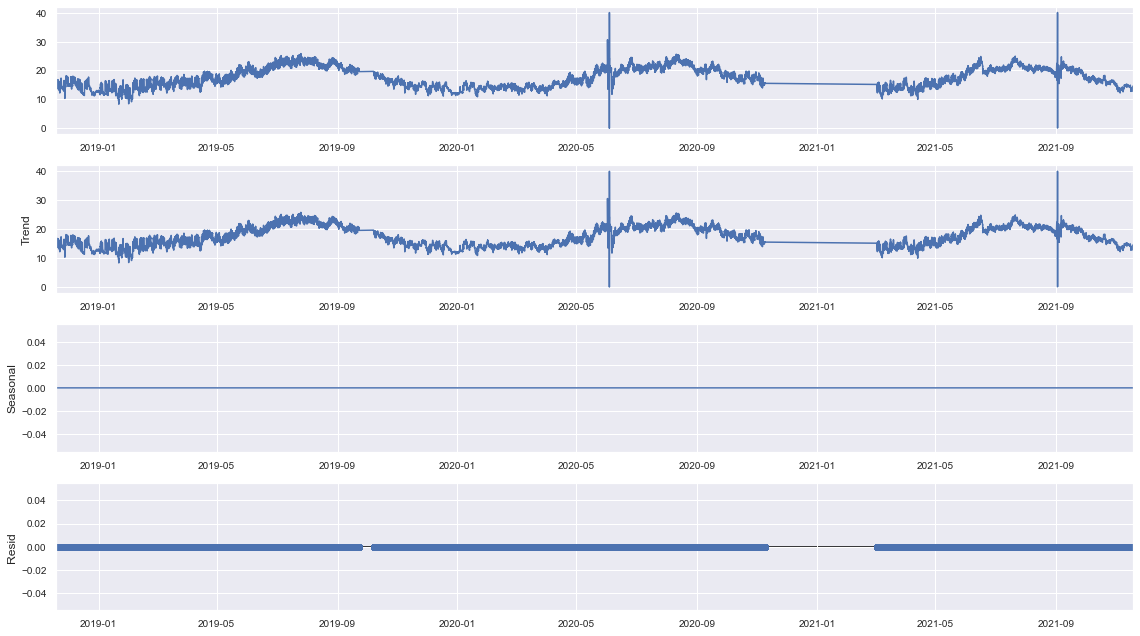

In [51]:
result = seasonal_decompose(df_i.dropna(), model='additive', period=1)
fig = result.plot()
fig.set_size_inches((16, 9))

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
# Tight layout to realign things
fig.tight_layout()
plt.show()

# Analysis for Device D (Storage)

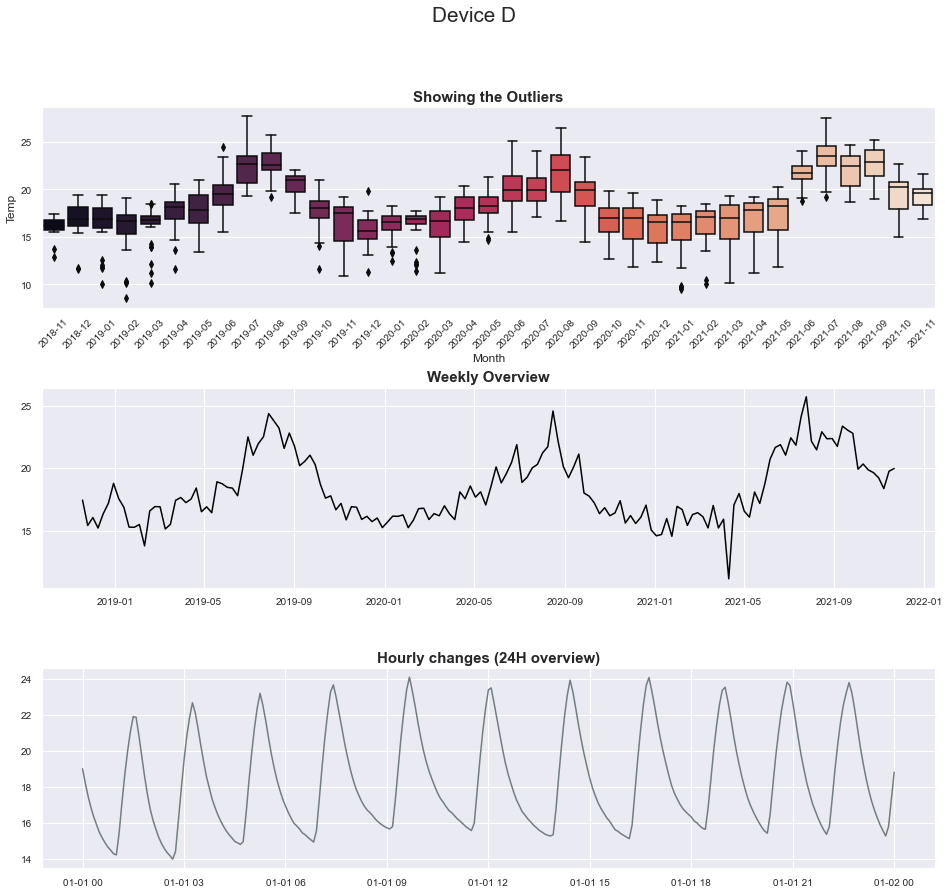

In [52]:
df_d_copy = df_d_daily.copy()
df_d_copy["Month"] = df_d_copy.index.to_period('M')

df_d_zoom = df_d.loc["2019-01-01 00:00:00":"2019-01-02 00:00:00"]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16,14))
plt.subplots_adjust(hspace=0.4)
sns.boxplot(ax=axes[0],x="Month",y="Temp",data=df_d_copy,palette = "rocket")
fig.suptitle('Device D',fontsize="xx-large")
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 45)
axes[1].plot(df_d_weekly,color='black' )
axes[2].plot(df_d_zoom,color='#717D7E')
axes[0].set_title('Showing the Outliers', fontsize=15,fontweight='bold')
axes[1].set_title('Weekly Overview', fontsize=15,fontweight='bold')
axes[2].set_title('Hourly changes (24H overview)', fontsize=15,fontweight='bold')

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.show()

## The Null Values in the Dataset of Device D
Here we can see that Device D has 2221 null values out of 315.648 values.

In [53]:
df_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315648 entries, 2018-11-18 16:15:00 to 2021-11-18 16:10:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Temp    313427 non-null  float64
dtypes: float64(1)
memory usage: 12.9 MB


In [54]:
df_d.isna().sum()

Temp    2221
dtype: int64

<AxesSubplot:ylabel='EventDt'>

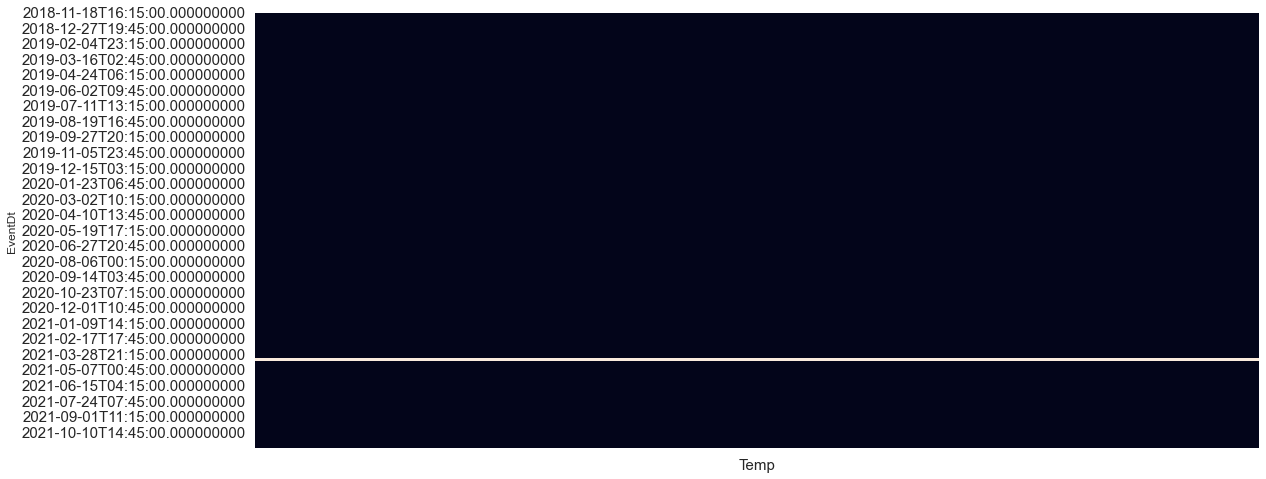

In [55]:
sns.heatmap(df_d.isnull(), cbar=False)

## Seasonal Decomposition of Device D
From the plot below we can see the actual dataset, we can the trend of the data, we can see if there's seasonality in the data, and lastly we can see if there's any residual in our data.

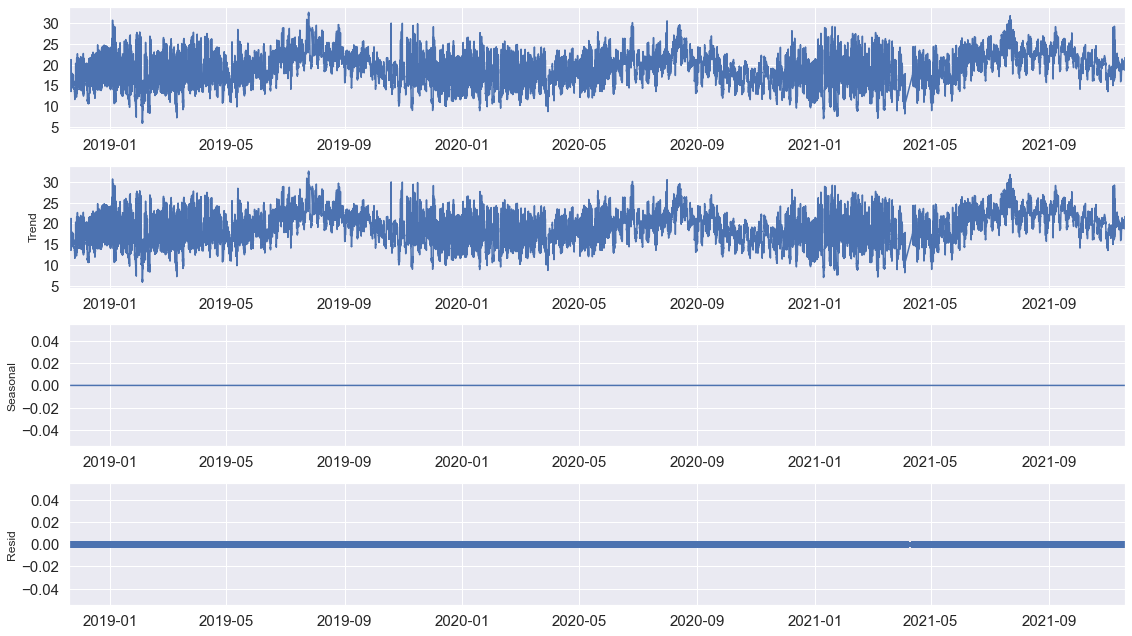

In [56]:
result = seasonal_decompose(df_d.dropna(), model='additive', period=1)
fig = result.plot()
fig.set_size_inches((16, 9))

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
# Tight layout to realign things
fig.tight_layout()
plt.show()

# Modeling

## Device I NeuralProphet prediction

In [57]:
m = NeuralProphet()
# help(m)

In [58]:
df_i_copy = df_i
df_i_copy

Temp
EventDt                   
2018-11-18 16:35:00  14.60
2018-11-18 16:40:00  14.63
2018-11-18 16:45:00  14.60
2018-11-18 16:50:00  14.57
2018-11-18 16:55:00  14.59
...                    ...
2021-11-18 16:10:00  14.65
2021-11-18 16:15:00  14.66
2021-11-18 16:20:00  14.64
2021-11-18 16:25:00  14.65
2021-11-18 16:30:00  14.64

[315648 rows x 1 columns]

In [59]:
def ChangeDatasetForNeural(data):
    data["ds"] = data.index
    data = data.rename(columns = {'Temp':'y'}, inplace = True)
    data

In [60]:
ChangeDatasetForNeural(df_i_copy)

In [61]:
df_i_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315648 entries, 2018-11-18 16:35:00 to 2021-11-18 16:30:00
Freq: 5T
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   y       278713 non-null  float64       
 1   ds      315648 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.3 MB


In [62]:
warnings.filterwarnings('ignore')

m = NeuralProphet(yearly_seasonality=True,
#                   weekly_seasonality=False, 
#                   daily_seasonality=False,
                    epochs=30
                 )

metrics = m.fit(df_i_copy, freq="D")
metrics

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 100.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T
INFO - (NP.forecaster.__handle_missing_data) - dropped 36935 NAN row in 'y'
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 128


  0%|          | 0/186 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.61E-02, min: 1.58E+00


  0%|          | 0/186 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.63E-02, min: 1.42E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.40E-02
Epoch[30/30]: 100%|█████████████| 30/30 [02:59<00:00,  6.00s/it, SmoothL1Loss=0.00125, MAE=0.881, RMSE=1.14, RegLoss=0]


SmoothL1Loss       MAE       RMSE  RegLoss
0       0.251143  9.938390  12.693402      0.0
1       0.001412  0.935357   1.212593      0.0
2       0.001569  0.990899   1.278661      0.0
3       0.002014  1.134406   1.449876      0.0
4       0.002464  1.261802   1.603875      0.0
5       0.002966  1.386519   1.757353      0.0
6       0.003557  1.515286   1.914423      0.0
7       0.003854  1.582960   1.996838      0.0
8       0.004067  1.627121   2.052441      0.0
9       0.004100  1.631702   2.054660      0.0
10      0.003974  1.604782   2.024698      0.0
11      0.003960  1.599195   2.019730      0.0
12      0.003855  1.584815   1.999265      0.0
13      0.003521  1.516965   1.914204      0.0
14      0.003335  1.476010   1.862965      0.0
15      0.003130  1.425357   1.804165      0.0
16      0.002816  1.352683   1.715302      0.0
17      0.002759  1.336140   1.694679      0.0
18      0.002486  1.266970   1.611582      0.0
19      0.002326  1.223989   1.558193      0.0
20      0.002143  1.171796   1.495663      0.0
21      0.001953  1.116944   1.427629      0.0
22      0.001838  1.082598   1.386023      0.0
23      0.001674  1.029225   1.321626      0.0
24      0.001562  0.993070   1.276627      0.0
25      0.001469  0.960185   1.237483      0.0
26      0.001387  0.931517   1.201037      0.0
27      0.001322  0.908767   1.172597      0.0
28      0.001274  0.890548   1.150397      0.0
29      0.001248  0.881310   1.138221      0.0

In [63]:
future = m.make_future_dataframe(df_i_copy, periods=365, n_historic_predictions=True)

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 100.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T


INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.884% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.884% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T


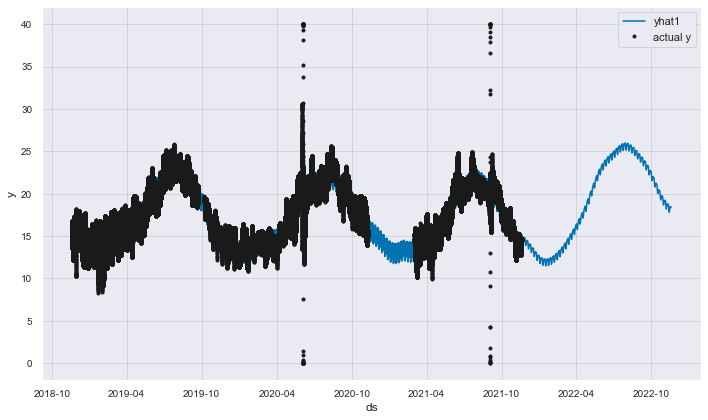

In [64]:
forecast = m.predict(future)
fig1 = m.plot(forecast)

In [65]:
forecast

ds      y      yhat1  residual1      trend  \
0      2018-11-18 16:35:00  14.60  15.351573   0.751573  17.605766   
1      2018-11-18 16:40:00  14.63  15.349663   0.719663  17.605852   
2      2018-11-18 16:45:00  14.60  15.347504   0.747504  17.605938   
3      2018-11-18 16:50:00  14.57  15.345086   0.775086  17.606024   
4      2018-11-18 16:55:00  14.59  15.342409   0.752409  17.606110   
...                    ...    ...        ...        ...        ...   
316008 2022-11-14 16:30:00    NaN  18.079643        NaN  19.792212   
316009 2022-11-15 16:30:00    NaN  18.350185        NaN  19.801172   
316010 2022-11-16 16:30:00    NaN  18.444935        NaN  19.810133   
316011 2022-11-17 16:30:00    NaN  18.415800        NaN  19.819092   
316012 2022-11-18 16:30:00    NaN  18.413427        NaN  19.828053   

        season_yearly  season_weekly  season_daily  
0           -2.483339      -0.528057      0.757201  
1           -2.483518      -0.527600      0.754930  
2           -2.483697      -0.527134      0.752397  
3           -2.483877      -0.526659      0.749598  
4           -2.484056      -0.526174      0.746528  
...               ...            ...           ...  
316008      -2.272707      -0.199075      0.759212  
316009      -2.326363       0.116165      0.759212  
316010      -2.379187       0.254777      0.759212  
316011      -2.431385       0.268881      0.759212  
316012      -2.483159       0.309322      0.759212  

[316013 rows x 8 columns]

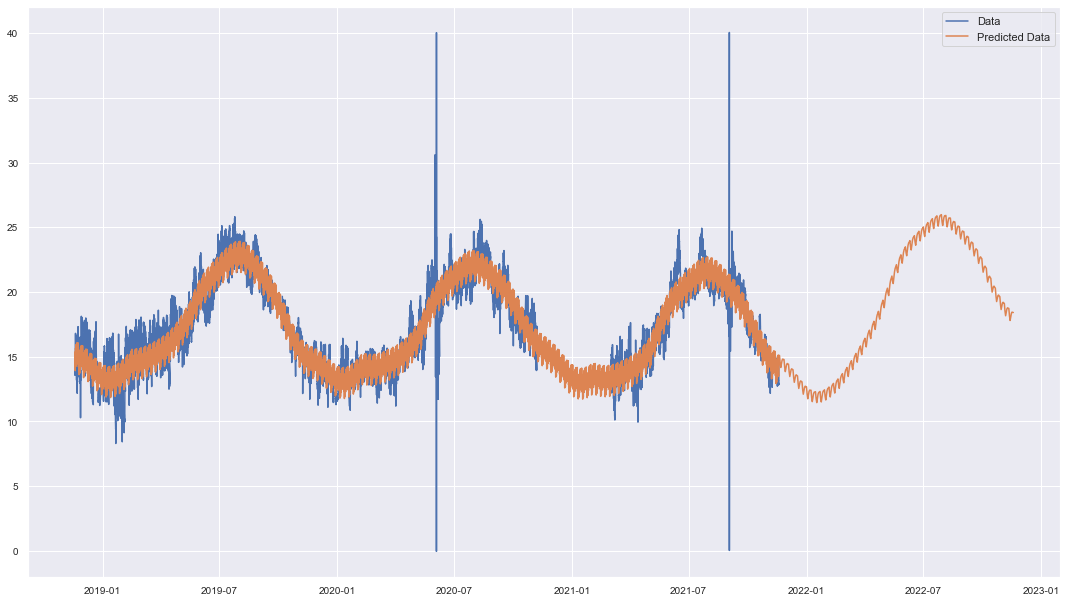

In [66]:
fig, ax = plt.subplots()
ax.plot(forecast["ds"],forecast["y"], label="Data")
ax.plot(forecast["ds"],forecast["yhat1"],label="Predicted Data")
ax.legend(loc = 'upper right')
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

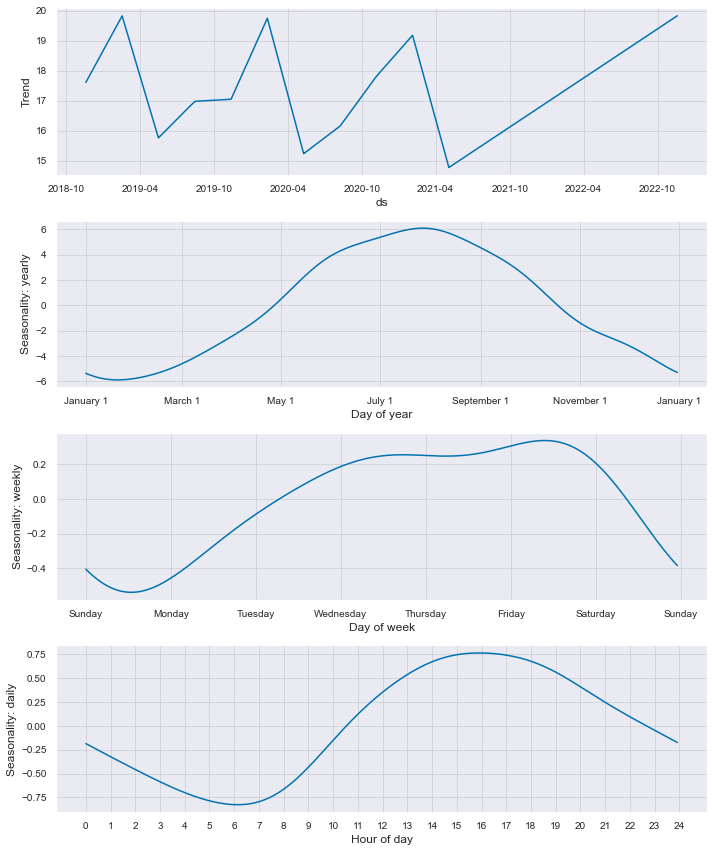

In [67]:
fig2 = m.plot_components(forecast)

In [68]:
## https://neuralprophet.com/html/test_and_crossvalidate.html
## Need to add crossvalidation

## Device K Predictions

In [69]:
df_k_daily

Temp
EventDt              
2018-11-18 -26.699659
2018-11-19 -26.833437
2018-11-20 -26.843924
2018-11-21 -26.860833
2018-11-22 -26.911181
...               ...
2021-11-14 -26.610556
2021-11-15 -26.636389
2021-11-16 -26.782951
2021-11-17 -26.773368
2021-11-18 -26.819950

[1097 rows x 1 columns]

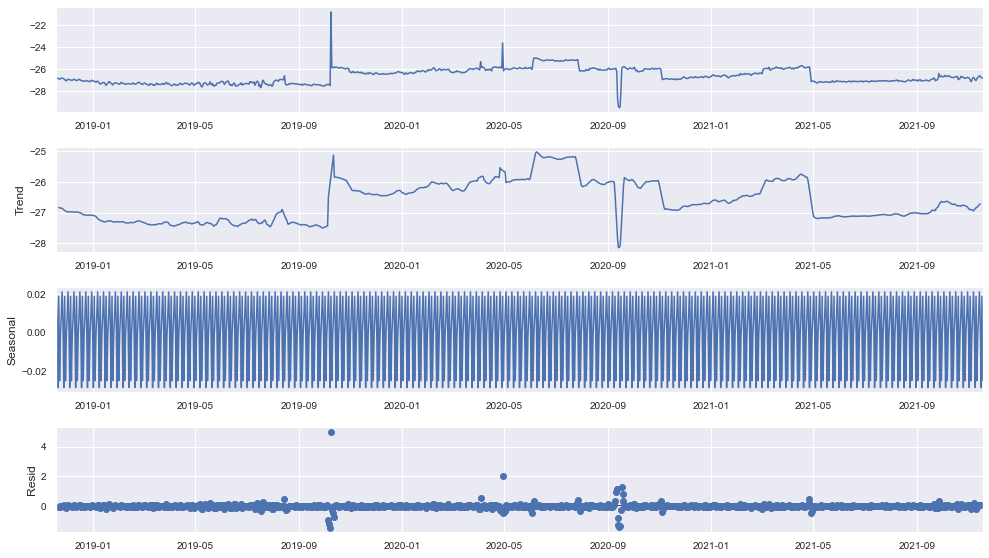

In [70]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(df_k_daily,model='additive')
fig = result.plot()

### Seasonal Arima model. Daily value prediction

In [71]:
model = sm.tsa.statespace.SARIMAX(df_k_daily['Temp'], 
                order=(1,1,1), 
                seasonal_order=(1,1,0,12))

sarima = model.fit()

predictions = sarima.predict()

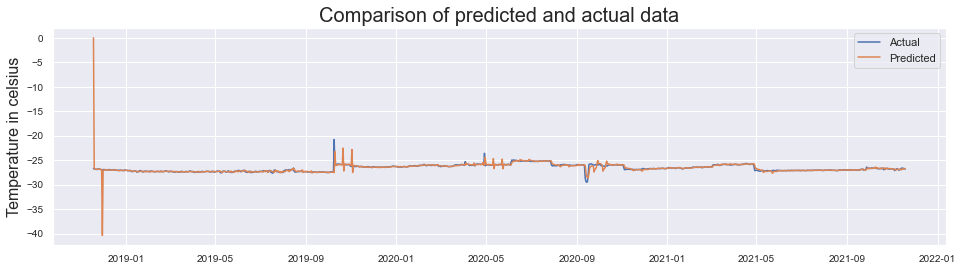

In [72]:
plt.figure(figsize=(16,4))
plt.plot(df_k_daily, label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Comparison of predicted and actual data', fontsize=20)
plt.ylabel('Temperature in celsius', fontsize=16)
plt.legend()

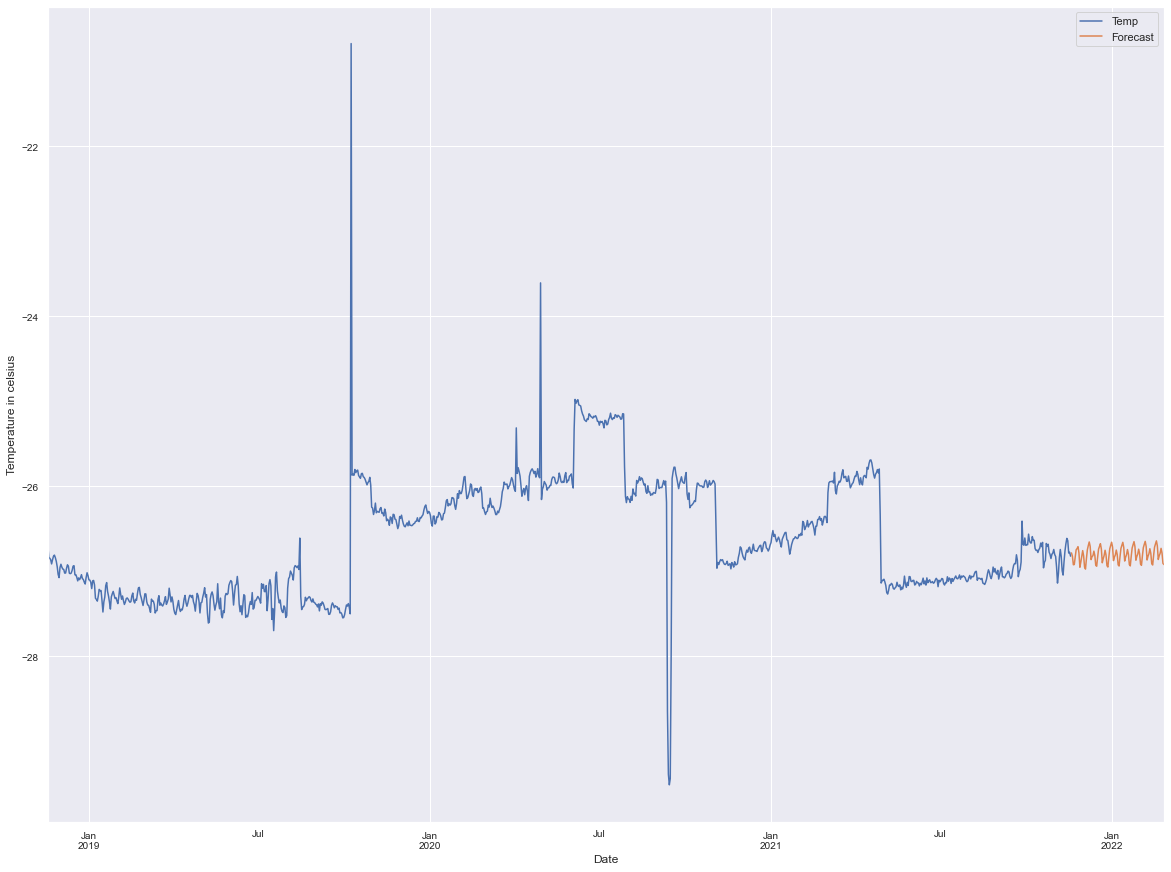

In [73]:
forecast = sarima.forecast(100)

ax = df_k_daily.plot(label='observed', figsize=(20, 15))
forecast.plot(ax=ax, label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Temperature in celsius')

plt.legend()
plt.show()

### Seasonal Auto-Arima model. Daily value prediction

In [74]:

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df_k_daily, start_p=1, start_q=1,
                         test='adf',
                         max_p=1, max_q=1, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.11 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1624.175, Time=0.20 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=812.863, Time=1.17 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=986.762, Time=1.31 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1622.177, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1078.422, Time=0.32 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=701.203, Time=2.95 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=11.50 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.97 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1438.837, Time=1.87 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=647.388, Time=5.03 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=772.897, Time=1.64 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=10.16 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=4.56 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1031

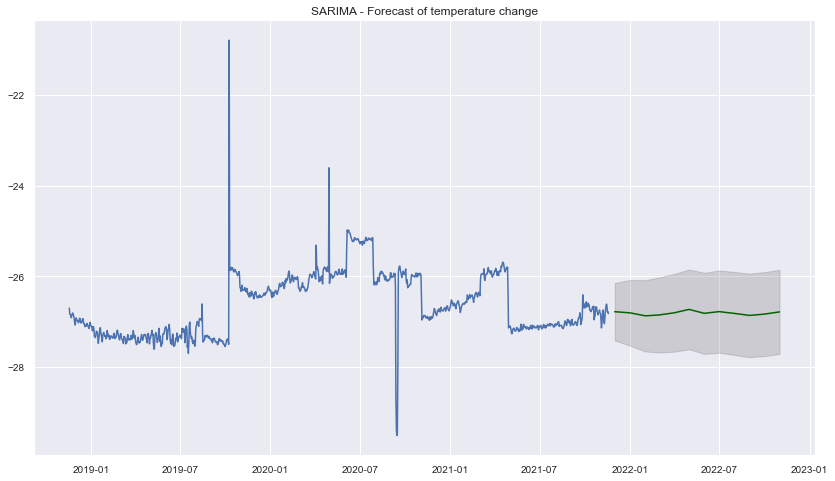

In [75]:
data = df_k_daily
# Forecast
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Forecast of temperature change")
plt.show()

### Seasonal Auto-Arima model. Hourly prediction

In [76]:
df_k_hourly = df_k.resample('H').mean()
df_k_hourly

Temp
EventDt                       
2018-11-18 16:00:00 -26.327500
2018-11-18 17:00:00 -26.729167
2018-11-18 18:00:00 -26.876667
2018-11-18 19:00:00 -26.638333
2018-11-18 20:00:00 -26.570833
...                        ...
2021-11-18 12:00:00 -26.644167
2021-11-18 13:00:00 -27.124167
2021-11-18 14:00:00 -26.960833
2021-11-18 15:00:00 -26.832500
2021-11-18 16:00:00 -26.922500

[26305 rows x 1 columns]

In [77]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df_k_hourly, start_p=1, start_q=1,
                         test='adf',
                         max_p=1, max_q=1, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=68.44 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=57074.132, Time=3.59 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=40597.371, Time=27.29 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=38.77 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=57072.133, Time=1.15 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=48515.830, Time=2.57 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=37728.162, Time=60.12 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=162.98 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=58.11 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=47275.548, Time=41.97 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=36942.459, Time=89.38 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=39674.235, Time=23.32 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=303.35 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=74.97 sec
 ARIMA(0,0,1)(2,1,0)[12] int

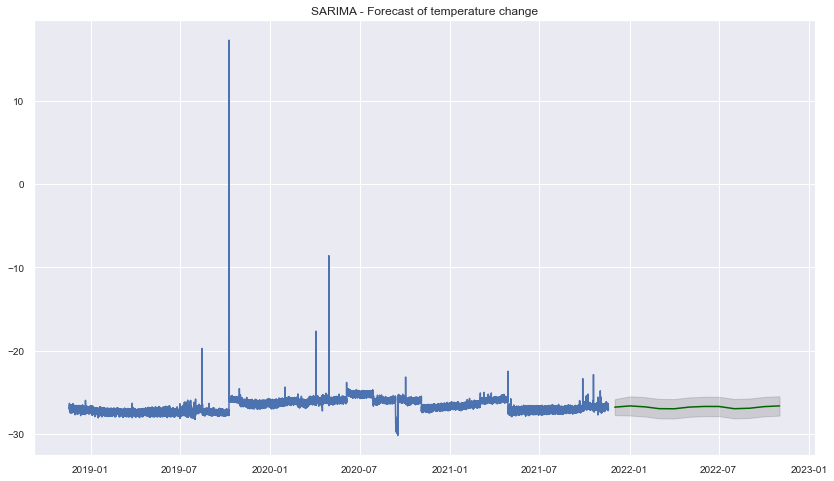

In [78]:
# Forecast
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df_k_hourly.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_k_hourly)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Forecast of temperature change")
plt.show()

### NeuralProphet model. Daily prediction

In [79]:
df_k_daily_copy = df_k_daily

In [80]:
ChangeDatasetForNeural(df_k_daily_copy)

In [81]:
df_k_daily_copy = df_k_daily_copy.rename(columns={"Temp": "y"})
df_k_daily_copy

y         ds
EventDt                         
2018-11-18 -26.699659 2018-11-18
2018-11-19 -26.833437 2018-11-19
2018-11-20 -26.843924 2018-11-20
2018-11-21 -26.860833 2018-11-21
2018-11-22 -26.911181 2018-11-22
...               ...        ...
2021-11-14 -26.610556 2021-11-14
2021-11-15 -26.636389 2021-11-15
2021-11-16 -26.782951 2021-11-16
2021-11-17 -26.773368 2021-11-17
2021-11-18 -26.819950 2021-11-18

[1097 rows x 2 columns]

In [82]:
warnings.filterwarnings('ignore')

model = NeuralProphet(yearly_seasonality=True,
                    epochs=30
                 )

result = model.fit(df_k_daily_copy, freq="D")
result

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


  0%|          | 0/126 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.64E-01, min: 1.12E-01


  0%|          | 0/126 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.86E-01, min: 2.21E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.84E-01
Epoch[30/30]: 100%|█████████████| 30/30 [00:02<00:00, 13.15it/s, SmoothL1Loss=0.00386, MAE=0.229, RMSE=0.33, RegLoss=0]


SmoothL1Loss       MAE      RMSE  RegLoss
0       0.722596  4.752173  5.888011      0.0
1       0.198368  2.111441  2.593766      0.0
2       0.047455  0.984504  1.229820      0.0
3       0.012739  0.516333  0.651406      0.0
4       0.010203  0.446513  0.582808      0.0
5       0.012379  0.497571  0.642866      0.0
6       0.021334  0.673184  0.851703      0.0
7       0.043930  0.958718  1.197312      0.0
8       0.070594  1.262058  1.552286      0.0
9       0.099181  1.474871  1.835929      0.0
10      0.078455  1.321685  1.641695      0.0
11      0.095058  1.442158  1.795326      0.0
12      0.059106  1.107027  1.415448      0.0
13      0.070078  1.205569  1.517190      0.0
14      0.024062  0.698259  0.894587      0.0
15      0.016489  0.584989  0.737280      0.0
16      0.013237  0.511940  0.660559      0.0
17      0.013265  0.516025  0.667010      0.0
18      0.009790  0.443637  0.568883      0.0
19      0.009866  0.436387  0.575413      0.0
20      0.007510  0.366310  0.494026      0.0
21      0.005395  0.298514  0.410671      0.0
22      0.006137  0.319080  0.444454      0.0
23      0.006136  0.318650  0.442215      0.0
24      0.004876  0.276664  0.389667      0.0
25      0.004847  0.264326  0.383439      0.0
26      0.004374  0.242531  0.362065      0.0
27      0.004122  0.241600  0.348075      0.0
28      0.003914  0.232186  0.340890      0.0
29      0.003863  0.229456  0.330447      0.0

In [83]:
future = model.make_future_dataframe(df_k_daily_copy, periods=365, n_historic_predictions=True)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


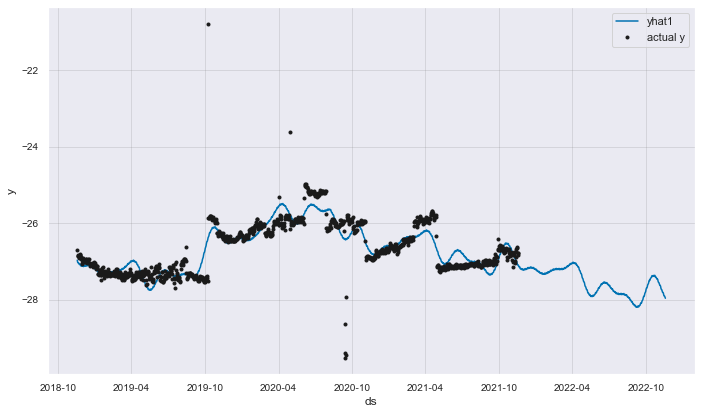

In [84]:
forecast = model.predict(future)
fig1 = model.plot(forecast)

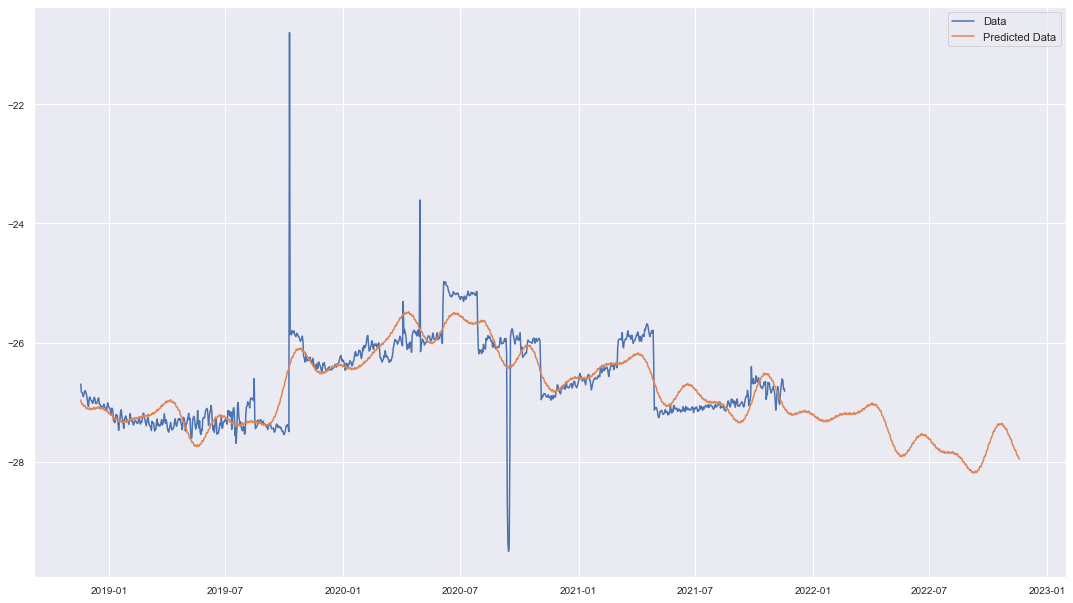

In [85]:
fig, ax = plt.subplots()
ax.plot(forecast["ds"],forecast["y"], label="Data")
ax.plot(forecast["ds"],forecast["yhat1"],label="Predicted Data")
ax.legend(loc = 'upper right')
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

### NeuralProphet mode. All data prediction

In [86]:
df_k_copy = df_k.copy()
df_k_copy

Temp
EventDt                   
2018-11-18 16:40:00 -25.93
2018-11-18 16:45:00 -26.14
2018-11-18 16:50:00 -26.44
2018-11-18 16:55:00 -26.80
2018-11-18 17:00:00 -27.04
...                    ...
2021-11-18 16:15:00 -26.95
2021-11-18 16:20:00 -26.76
2021-11-18 16:25:00 -26.54
2021-11-18 16:30:00 -26.54
2021-11-18 16:35:00 -26.77

[315648 rows x 1 columns]

In [87]:
ChangeDatasetForNeural(df_k_copy)
df_k_copy = df_k_copy.rename(columns={"Temp": "y"})
df_k_copy

y                  ds
EventDt                                       
2018-11-18 16:40:00 -25.93 2018-11-18 16:40:00
2018-11-18 16:45:00 -26.14 2018-11-18 16:45:00
2018-11-18 16:50:00 -26.44 2018-11-18 16:50:00
2018-11-18 16:55:00 -26.80 2018-11-18 16:55:00
2018-11-18 17:00:00 -27.04 2018-11-18 17:00:00
...                    ...                 ...
2021-11-18 16:15:00 -26.95 2021-11-18 16:15:00
2021-11-18 16:20:00 -26.76 2021-11-18 16:20:00
2021-11-18 16:25:00 -26.54 2021-11-18 16:25:00
2021-11-18 16:30:00 -26.54 2021-11-18 16:30:00
2021-11-18 16:35:00 -26.77 2021-11-18 16:35:00

[315648 rows x 2 columns]

In [88]:
warnings.filterwarnings('ignore')

model = NeuralProphet(yearly_seasonality=True,
                    epochs=30
                 )

result = model.fit(df_k_copy, freq="D")
result

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 100.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T
INFO - (NP.forecaster.__handle_missing_data) - dropped 59 NAN row in 'y'
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 128


  0%|          | 0/187 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.58E-02, min: 1.62E+00


  0%|          | 0/187 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.58E-02, min: 1.45E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.95E-02
Epoch[30/30]: 100%|█████████████| 30/30 [03:28<00:00,  6.95s/it, SmoothL1Loss=0.0077, MAE=0.457, RMSE=0.628, RegLoss=0]


SmoothL1Loss       MAE      RMSE  RegLoss
0       0.159413  1.905295  2.325524      0.0
1       0.009389  0.515052  0.696754      0.0
2       0.008709  0.490494  0.669914      0.0
3       0.008961  0.497534  0.679462      0.0
4       0.009458  0.511981  0.699305      0.0
5       0.010009  0.528806  0.719720      0.0
6       0.010327  0.537831  0.731403      0.0
7       0.010846  0.553007  0.750001      0.0
8       0.010946  0.555615  0.753205      0.0
9       0.010968  0.556052  0.753949      0.0
10      0.010951  0.555691  0.753604      0.0
11      0.010817  0.552153  0.749287      0.0
12      0.010702  0.548686  0.744423      0.0
13      0.010566  0.544913  0.739940      0.0
14      0.010390  0.539747  0.733671      0.0
15      0.010165  0.533388  0.725354      0.0
16      0.009959  0.527761  0.717574      0.0
17      0.009756  0.521030  0.710422      0.0
18      0.009503  0.513182  0.700689      0.0
19      0.009288  0.506641  0.692550      0.0
20      0.009021  0.498614  0.681823      0.0
21      0.008813  0.492196  0.673054      0.0
22      0.008597  0.485354  0.666118      0.0
23      0.008409  0.479702  0.657439      0.0
24      0.008223  0.473906  0.650052      0.0
25      0.008072  0.469270  0.643430      0.0
26      0.007927  0.464829  0.637495      0.0
27      0.007812  0.461009  0.633195      0.0
28      0.007738  0.458684  0.629307      0.0
29      0.007696  0.457473  0.627697      0.0

In [89]:
future = model.make_future_dataframe(df_k_copy, periods=365, n_historic_predictions=True)


INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 100.0% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T


INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.884% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.884% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T


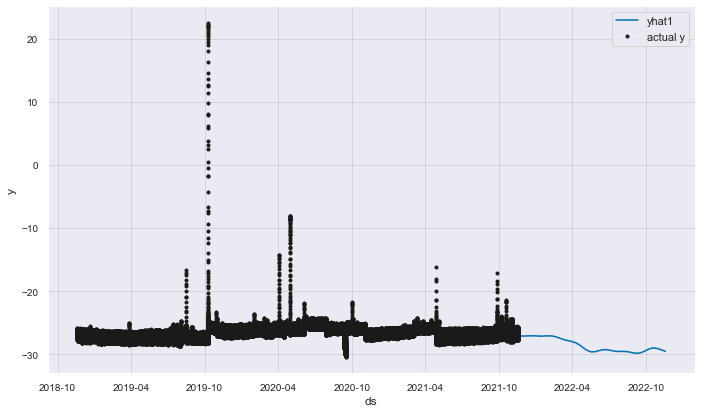

In [90]:
forecast = model.predict(future)
fig1 = model.plot(forecast)

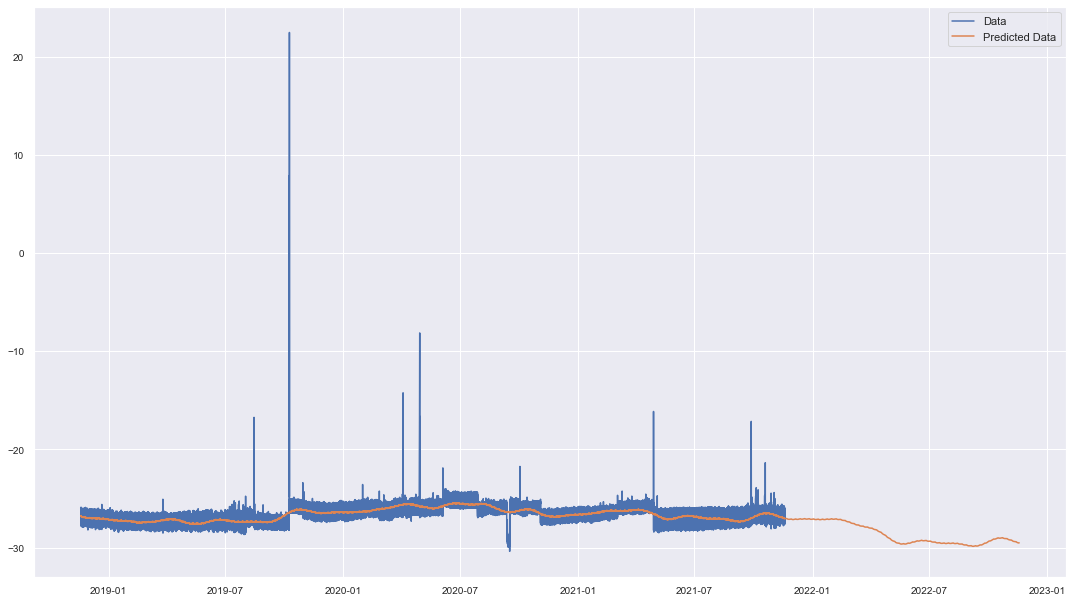

In [91]:
fig, ax = plt.subplots()
ax.plot(forecast["ds"],forecast["y"], label="Data")
ax.plot(forecast["ds"],forecast["yhat1"],label="Predicted Data")
ax.legend(loc = 'upper right')
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

### XGBoost mode. All data prediction

In [438]:
temp = df_k.dropna()
DfKhourly = temp.resample('H').mean()
DfKhourly

Temp
EventDt                       
2018-11-18 16:00:00 -26.327500
2018-11-18 17:00:00 -26.729167
2018-11-18 18:00:00 -26.876667
2018-11-18 19:00:00 -26.638333
2018-11-18 20:00:00 -26.570833
...                        ...
2021-11-18 12:00:00 -26.644167
2021-11-18 13:00:00 -27.124167
2021-11-18 14:00:00 -26.960833
2021-11-18 15:00:00 -26.832500
2021-11-18 16:00:00 -26.922500

[26305 rows x 1 columns]

In [439]:
df_k_dailycopy = DfKhourly.reset_index()
df_k_dailycopy

EventDt       Temp
0     2018-11-18 16:00:00 -26.327500
1     2018-11-18 17:00:00 -26.729167
2     2018-11-18 18:00:00 -26.876667
3     2018-11-18 19:00:00 -26.638333
4     2018-11-18 20:00:00 -26.570833
...                   ...        ...
26300 2021-11-18 12:00:00 -26.644167
26301 2021-11-18 13:00:00 -27.124167
26302 2021-11-18 14:00:00 -26.960833
26303 2021-11-18 15:00:00 -26.832500
26304 2021-11-18 16:00:00 -26.922500

[26305 rows x 2 columns]

In [440]:
df_k_dailycopy['EventDt'] = pd.to_datetime(df_k_dailycopy['EventDt'])
#df_k_dailycopy['dayofweek'] = df_k_dailycopy['EventDt'].dt.dayofweek
#df_k_dailycopy['quarter'] = df_k_dailycopy['EventDt'].dt.quarter
df_k_dailycopy['month'] = df_k_dailycopy['EventDt'].dt.month
df_k_dailycopy['year'] = df_k_dailycopy['EventDt'].dt.year
df_k_dailycopy['dayofyear'] = df_k_dailycopy['EventDt'].dt.dayofyear
#df_k_dailycopy['sin_day'] = np.sin(df_k_dailycopy['dayofyear'])
#df_k_dailycopy['cos_day'] = np.cos(df_k_dailycopy['dayofyear'])
df_k_dailycopy['dayofmonth'] = df_k_dailycopy['EventDt'].dt.day
df_k_dailycopy['weekofyear'] = df_k_dailycopy['EventDt'].dt.weekofyear

In [441]:
df_k_dailycopy

EventDt       Temp  month  year  dayofyear  dayofmonth  \
0     2018-11-18 16:00:00 -26.327500     11  2018        322          18   
1     2018-11-18 17:00:00 -26.729167     11  2018        322          18   
2     2018-11-18 18:00:00 -26.876667     11  2018        322          18   
3     2018-11-18 19:00:00 -26.638333     11  2018        322          18   
4     2018-11-18 20:00:00 -26.570833     11  2018        322          18   
...                   ...        ...    ...   ...        ...         ...   
26300 2021-11-18 12:00:00 -26.644167     11  2021        322          18   
26301 2021-11-18 13:00:00 -27.124167     11  2021        322          18   
26302 2021-11-18 14:00:00 -26.960833     11  2021        322          18   
26303 2021-11-18 15:00:00 -26.832500     11  2021        322          18   
26304 2021-11-18 16:00:00 -26.922500     11  2021        322          18   

       weekofyear  
0              46  
1              46  
2              46  
3              46  
4              46  
...           ...  
26300          46  
26301          46  
26302          46  
26303          46  
26304          46  

[26305 rows x 7 columns]

In [442]:
df_k_dailycopy = df_k_dailycopy.drop(['EventDt'],axis = 1 )
df_k_dailycopy

Temp  month  year  dayofyear  dayofmonth  weekofyear
0     -26.327500     11  2018        322          18          46
1     -26.729167     11  2018        322          18          46
2     -26.876667     11  2018        322          18          46
3     -26.638333     11  2018        322          18          46
4     -26.570833     11  2018        322          18          46
...          ...    ...   ...        ...         ...         ...
26300 -26.644167     11  2021        322          18          46
26301 -27.124167     11  2021        322          18          46
26302 -26.960833     11  2021        322          18          46
26303 -26.832500     11  2021        322          18          46
26304 -26.922500     11  2021        322          18          46

[26305 rows x 6 columns]

In [443]:
df_k_dailycopy.shape[0]

26305

In [444]:
Xpercentage = df_k_dailycopy.shape[0] * 0.8
Xpercentage = round(Xpercentage)
Xpercentage

21044

In [445]:
x = df_k_dailycopy[:Xpercentage]
XBost_Train = x.drop(['Temp'],axis=1)
YBost_Train = x['Temp']
XBost_Train

month  year  dayofyear  dayofmonth  weekofyear
0         11  2018        322          18          46
1         11  2018        322          18          46
2         11  2018        322          18          46
3         11  2018        322          18          46
4         11  2018        322          18          46
...      ...   ...        ...         ...         ...
21039      4  2021        103          13          15
21040      4  2021        103          13          15
21041      4  2021        103          13          15
21042      4  2021        103          13          15
21043      4  2021        103          13          15

[21044 rows x 5 columns]

In [446]:
y = df_k_dailycopy[Xpercentage:]
XBost_Test = y.drop(['Temp'],axis=1)
YBost_Test = y['Temp']
YBost_Test

21044   -26.245000
21045   -25.808333
21046   -25.810833
21047   -25.974167
21048   -26.330833
           ...    
26300   -26.644167
26301   -27.124167
26302   -26.960833
26303   -26.832500
26304   -26.922500
Name: Temp, Length: 5261, dtype: float64

In [447]:
XBost_Train

month  year  dayofyear  dayofmonth  weekofyear
0         11  2018        322          18          46
1         11  2018        322          18          46
2         11  2018        322          18          46
3         11  2018        322          18          46
4         11  2018        322          18          46
...      ...   ...        ...         ...         ...
21039      4  2021        103          13          15
21040      4  2021        103          13          15
21041      4  2021        103          13          15
21042      4  2021        103          13          15
21043      4  2021        103          13          15

[21044 rows x 5 columns]

In [448]:
XBost_Test

month  year  dayofyear  dayofmonth  weekofyear
21044      4  2021        103          13          15
21045      4  2021        103          13          15
21046      4  2021        103          13          15
21047      4  2021        103          13          15
21048      4  2021        103          13          15
...      ...   ...        ...         ...         ...
26300     11  2021        322          18          46
26301     11  2021        322          18          46
26302     11  2021        322          18          46
26303     11  2021        322          18          46
26304     11  2021        322          18          46

[5261 rows x 5 columns]

In [449]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(XBost_Train, YBost_Train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(XBost_Test)

In [450]:
print(r2_score(YBost_Test, yhat))

-7.746044819160151


In [451]:
from sklearn.model_selection import GridSearchCV

params = {
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}
# Initialize XGB and GridSearch
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')
grid = GridSearchCV(xgb_reg, params)
grid.fit(XBost_Train, YBost_Train)
gridcv_xgb = grid.best_estimator_
print(r2_score(YBost_Test, gridcv_xgb.predict(XBost_Test)))


-7.121509195351324


In [452]:
yhat = reg.predict(XBost_Test)

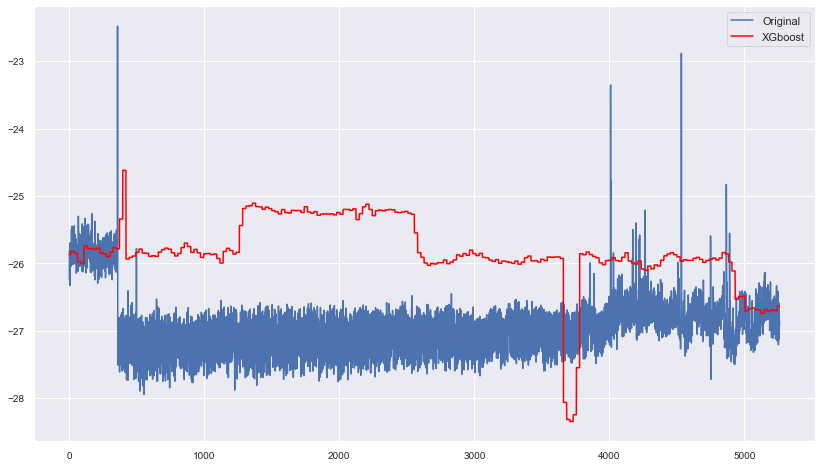

In [453]:
plt.plot(YBost_Test.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

## Device S predictions

In [92]:
df_s_daily

Temp
EventDt             
2018-11-18  1.119767
2018-11-19  1.457917
2018-11-20  1.675347
2018-11-21  1.848229
2018-11-22  1.921597
...              ...
2021-11-14  1.146146
2021-11-15  1.027743
2021-11-16  1.436840
2021-11-17  1.883576
2021-11-18  1.571294

[1097 rows x 1 columns]

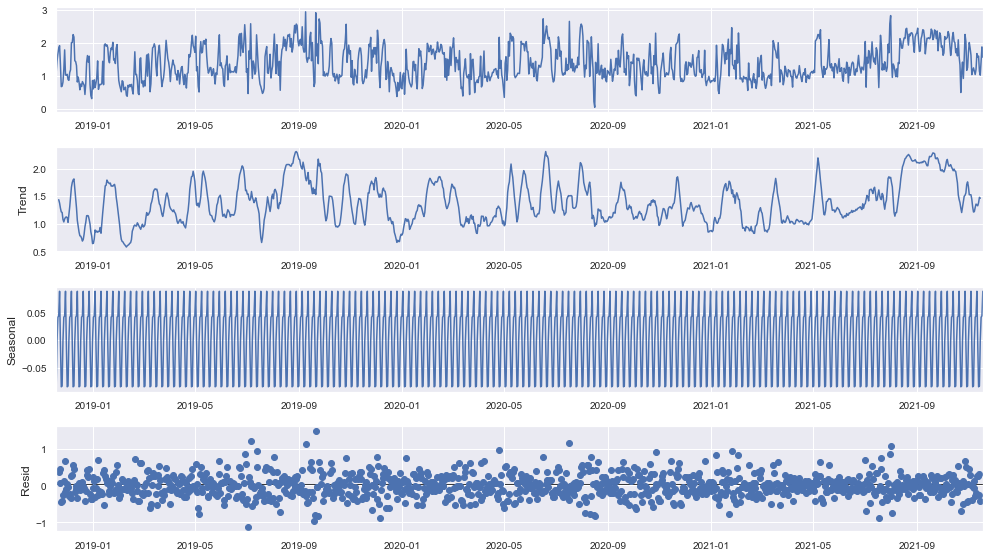

In [93]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(df_s_daily,model='additive')
fig = result.plot()

### Seasonal Arima model. Daily value prediction

In [94]:
model = sm.tsa.statespace.SARIMAX(df_s_daily, 
                order=(1,1,1), 
                seasonal_order=(1,1,0,12))

sarima = model.fit()

predictions = sarima.predict()

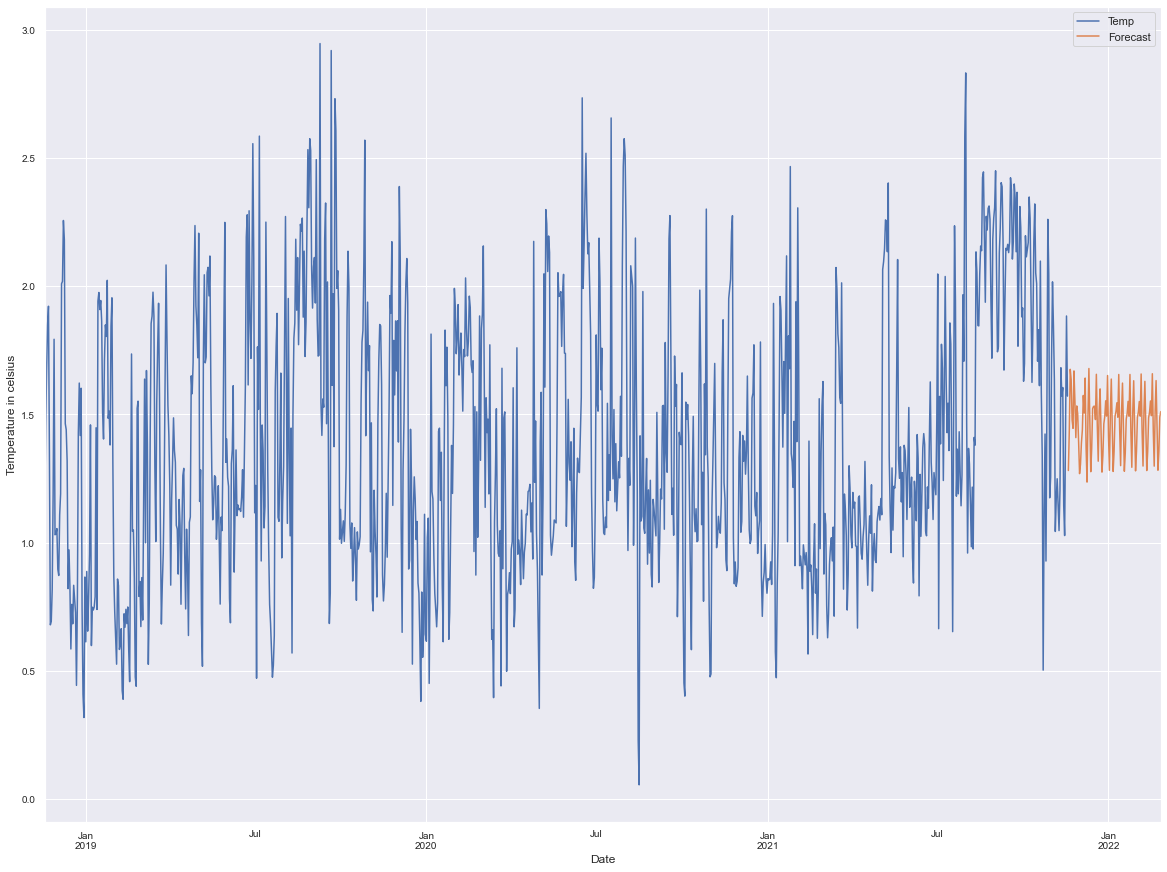

In [95]:
forecast = sarima.forecast(100)

ax = df_s_daily.plot(label='observed', figsize=(20, 15))
forecast.plot(ax=ax, label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Temperature in celsius')

plt.legend()
plt.show()

### Seasonal Auto-Arima model. Daily value prediction

In [96]:

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df_s_daily, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.86 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2103.867, Time=0.29 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1395.603, Time=0.96 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.99 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2101.869, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1642.911, Time=0.28 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1261.711, Time=2.94 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=9.22 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.38 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1807.304, Time=3.52 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1263.513, Time=3.20 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1263.498, Time=3.76 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1425.932, Time=2.29 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1262.776, Time=10.64 sec
 ARIMA(1,0,0)(2,1,0)[12]             :

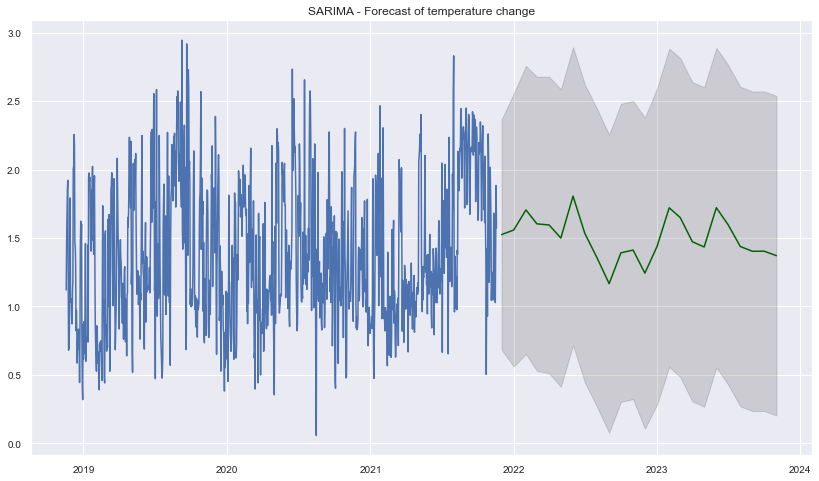

In [97]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df_s_daily.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_s_daily)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Forecast of temperature change")
plt.show()

### NeuralProphet model. Daily Prediction

In [98]:
df_s_daily_copy = df_s_daily

In [99]:
ChangeDatasetForNeural(df_s_daily_copy)

In [100]:
df_s_daily_copy = df_s_daily_copy.rename(columns={"Temp": "y"})
df_s_daily_copy

y         ds
EventDt                        
2018-11-18  1.119767 2018-11-18
2018-11-19  1.457917 2018-11-19
2018-11-20  1.675347 2018-11-20
2018-11-21  1.848229 2018-11-21
2018-11-22  1.921597 2018-11-22
...              ...        ...
2021-11-14  1.146146 2021-11-14
2021-11-15  1.027743 2021-11-15
2021-11-16  1.436840 2021-11-16
2021-11-17  1.883576 2021-11-17
2021-11-18  1.571294 2021-11-18

[1097 rows x 2 columns]

In [101]:
warnings.filterwarnings('ignore')

model = NeuralProphet(yearly_seasonality=True,
                    epochs=100
                 )

result = model.fit(df_s_daily_copy, freq="D")
result

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


  0%|          | 0/126 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.75E-02, min: 8.17E-01


  0%|          | 0/126 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.75E-02, min: 9.64E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.92E-02
Epoch[100/100]: 100%|█████████| 100/100 [00:07<00:00, 13.00it/s, SmoothL1Loss=0.0207, MAE=0.365, RMSE=0.445, RegLoss=0]


SmoothL1Loss       MAE      RMSE  RegLoss
0       0.642776  2.310007  2.814086      0.0
1       0.584100  2.167862  2.642071      0.0
2       0.493778  1.944325  2.372890      0.0
3       0.358997  1.593359  1.960289      0.0
4       0.199859  1.132553  1.415400      0.0
..           ...       ...       ...      ...
95      0.020708  0.365521  0.446163      0.0
96      0.020694  0.365085  0.445065      0.0
97      0.020686  0.364840  0.445405      0.0
98      0.020672  0.364693  0.446204      0.0
99      0.020666  0.364681  0.444660      0.0

[100 rows x 4 columns]

In [102]:
future = model.make_future_dataframe(df_s_daily_copy, periods=365, n_historic_predictions=True)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


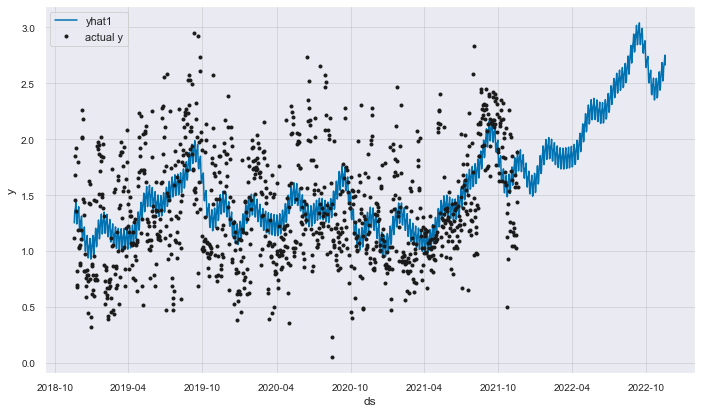

In [103]:
forecast = model.predict(future)
fig1 = model.plot(forecast)

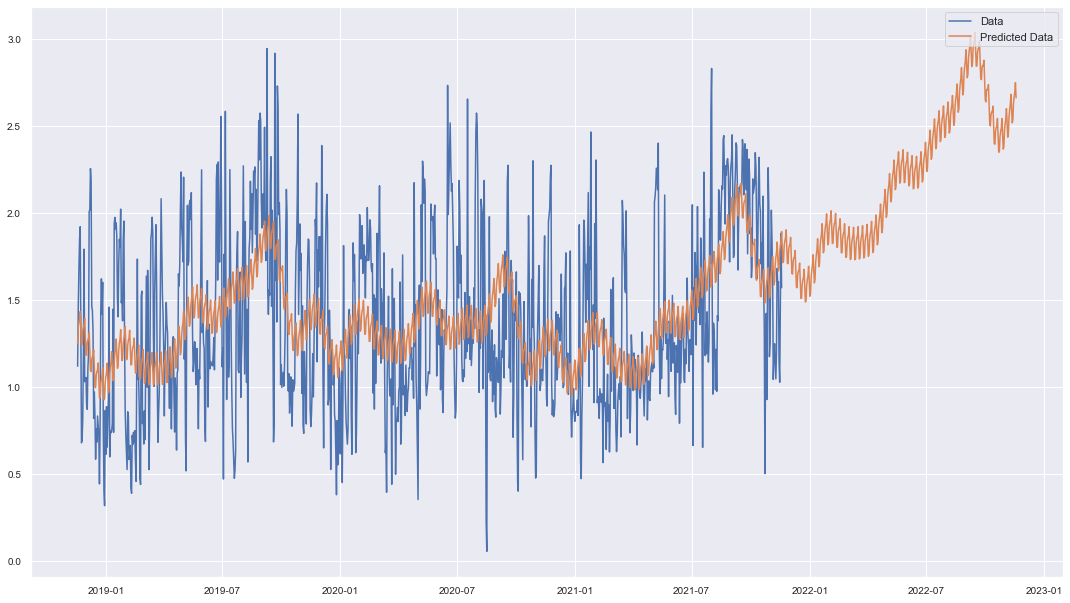

In [104]:
fig, ax = plt.subplots()
ax.plot(forecast["ds"],forecast["y"], label="Data")
ax.plot(forecast["ds"],forecast["yhat1"],label="Predicted Data")
ax.legend(loc = 'upper right')
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

## Device D predictions

### Seasonal Auto-Arima model. Daily value prediction

In [105]:
df_d_daily

Temp
EventDt              
2018-11-18  17.452258
2018-11-19  16.783854
2018-11-20  15.723333
2018-11-21  16.444618
2018-11-22  16.489757
...               ...
2021-11-14  16.897604
2021-11-15  19.999410
2021-11-16  20.337917
2021-11-17  19.501250
2021-11-18  20.134000

[1097 rows x 1 columns]

In [106]:
df_d_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1097 entries, 2018-11-18 to 2021-11-18
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    1091 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB


In [107]:
df_d_daily_copy = df_d_daily.copy()
df_d_daily_copy = df_d_daily_copy.dropna()
df_d_daily_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1091 entries, 2018-11-18 to 2021-11-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    1091 non-null   float64
dtypes: float64(1)
memory usage: 17.0 KB


In [108]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df_d_daily_copy, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.72 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=5590.480, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4917.078, Time=0.59 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=4595.859, Time=0.76 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=5588.675, Time=0.05 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=5055.247, Time=0.24 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=4592.760, Time=1.03 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=4768.774, Time=0.64 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=4576.798, Time=2.52 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=4607.602, Time=2.05 sec
 ARIMA(0,0,1)(2,1,2)[12] intercept   : AIC=4577.383, Time=4.05 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=4589.888, Time=4.60 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=5111.374, Time=1.99 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=12.99 sec
 ARIMA(0,0,2)(2,1,1)[12] int

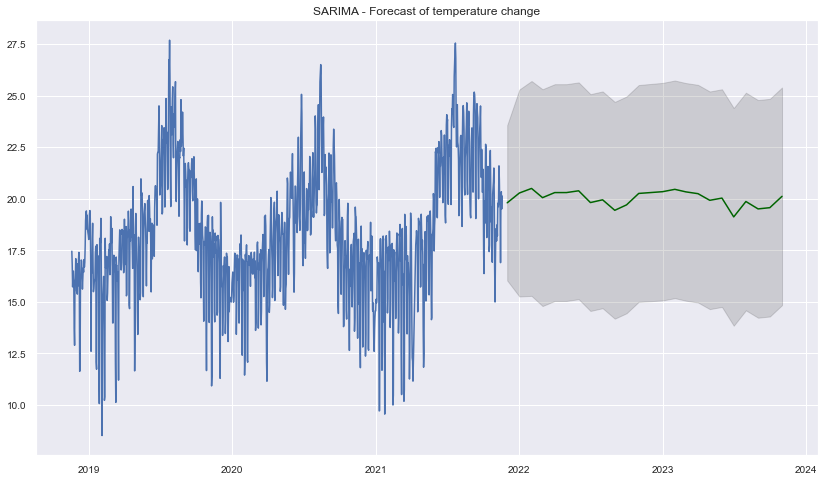

In [109]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df_d_daily_copy.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_d_daily_copy)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Forecast of temperature change")
plt.show()

### NeuralProphet model. Daily prediction

In [110]:
df_d_daily_copy = df_d_daily

In [111]:
ChangeDatasetForNeural(df_d_daily_copy)

In [112]:
df_d_daily_copy = df_d_daily_copy.rename(columns={"Temp": "y"})
df_d_daily_copy = df_d_daily_copy.dropna()

In [113]:
df_d_daily_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1091 entries, 2018-11-18 to 2021-11-18
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       1091 non-null   float64       
 1   ds      1091 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 25.6 KB


In [114]:
warnings.filterwarnings('ignore')

model = NeuralProphet(yearly_seasonality=True,
                    epochs=30
                 )

result = model.fit(df_d_daily_copy, freq="D")
result

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


  0%|          | 0/126 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.12E-01, min: 1.14E+00


  0%|          | 0/126 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.12E-01, min: 3.02E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.08E-01
Epoch[30/30]: 100%|██████████████| 30/30 [00:02<00:00, 13.06it/s, SmoothL1Loss=0.00472, MAE=1.14, RMSE=1.47, RegLoss=0]


SmoothL1Loss        MAE       RMSE  RegLoss
0       0.711959  17.211176  20.989843      0.0
1       0.496853  13.492520  16.549795      0.0
2       0.111924   5.468931   6.809098      0.0
3       0.013788   2.021786   2.514104      0.0
4       0.006707   1.371262   1.757663      0.0
5       0.005760   1.281369   1.634397      0.0
6       0.006731   1.388209   1.759245      0.0
7       0.006583   1.372547   1.744199      0.0
8       0.007289   1.447086   1.825793      0.0
9       0.007249   1.441548   1.826342      0.0
10      0.006933   1.405472   1.774712      0.0
11      0.007424   1.469429   1.846763      0.0
12      0.006844   1.400090   1.782067      0.0
13      0.007322   1.444138   1.838226      0.0
14      0.007141   1.452503   1.812938      0.0
15      0.008413   1.562552   1.961915      0.0
16      0.006672   1.396961   1.752134      0.0
17      0.007448   1.437833   1.842169      0.0
18      0.006356   1.341575   1.718188      0.0
19      0.006105   1.308555   1.677937      0.0
20      0.006295   1.338576   1.703760      0.0
21      0.005535   1.238495   1.600146      0.0
22      0.005476   1.242970   1.586388      0.0
23      0.005628   1.253943   1.602943      0.0
24      0.005346   1.214833   1.563935      0.0
25      0.005142   1.199360   1.541039      0.0
26      0.004975   1.162023   1.514365      0.0
27      0.004800   1.150675   1.491656      0.0
28      0.004739   1.140542   1.466336      0.0
29      0.004720   1.136396   1.471541      0.0

In [115]:
future = model.make_future_dataframe(df_d_daily_copy, periods=365, n_historic_predictions=True)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


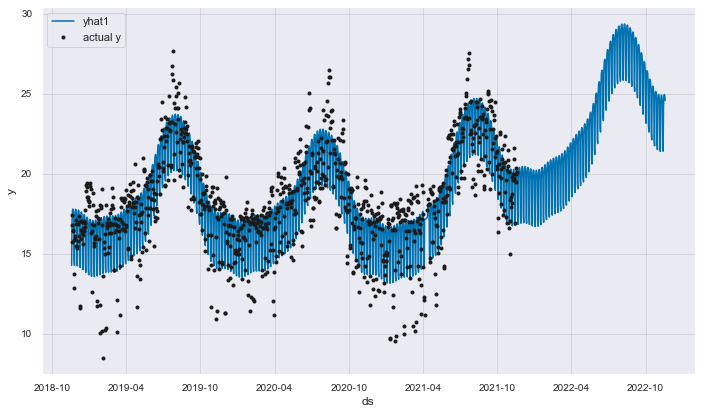

In [116]:
forecast = model.predict(future)
fig1 = model.plot(forecast)

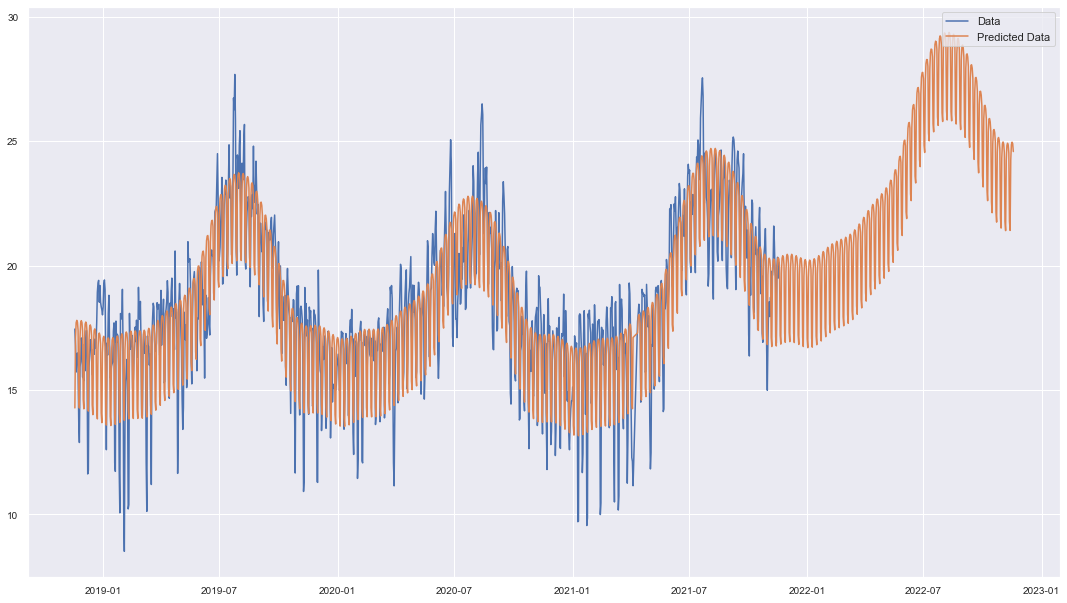

In [117]:
fig, ax = plt.subplots()
ax.plot(forecast["ds"],forecast["y"], label="Data")
ax.plot(forecast["ds"],forecast["yhat1"],label="Predicted Data")
ax.legend(loc = 'upper right')
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

### NeuralProphet mode. All data prediction

In [118]:
df_d_copy = df_d.copy()
df_d_copy = df_d_copy.dropna()
df_d_copy

Temp
EventDt                   
2018-11-18 16:15:00  15.16
2018-11-18 16:20:00  15.03
2018-11-18 16:25:00  14.88
2018-11-18 16:30:00  14.82
2018-11-18 16:35:00  15.96
...                    ...
2021-11-18 15:50:00  21.53
2021-11-18 15:55:00  21.47
2021-11-18 16:00:00  21.62
2021-11-18 16:05:00  21.58
2021-11-18 16:10:00  21.66

[313427 rows x 1 columns]

In [119]:
ChangeDatasetForNeural(df_d_copy)
df_d_copy = df_d_copy.rename(columns={"Temp": "y"})
df_d_copy

y                  ds
EventDt                                       
2018-11-18 16:15:00  15.16 2018-11-18 16:15:00
2018-11-18 16:20:00  15.03 2018-11-18 16:20:00
2018-11-18 16:25:00  14.88 2018-11-18 16:25:00
2018-11-18 16:30:00  14.82 2018-11-18 16:30:00
2018-11-18 16:35:00  15.96 2018-11-18 16:35:00
...                    ...                 ...
2021-11-18 15:50:00  21.53 2021-11-18 15:50:00
2021-11-18 15:55:00  21.47 2021-11-18 15:55:00
2021-11-18 16:00:00  21.62 2021-11-18 16:00:00
2021-11-18 16:05:00  21.58 2021-11-18 16:05:00
2021-11-18 16:10:00  21.66 2021-11-18 16:10:00

[313427 rows x 2 columns]

In [120]:
warnings.filterwarnings('ignore')

model = NeuralProphet(yearly_seasonality=True,
                    epochs=30
                 )

result = model.fit(df_d_copy, freq="D")
result

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.968% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 128


  0%|          | 0/187 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.26E+00


  0%|          | 0/187 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.95E-02, min: 1.75E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.64E-02
Epoch[30/30]: 100%|██████████████| 30/30 [03:27<00:00,  6.92s/it, SmoothL1Loss=0.00793, MAE=1.74, RMSE=2.34, RegLoss=0]


SmoothL1Loss        MAE       RMSE  RegLoss
0       0.550778  16.610385  19.815093      0.0
1       0.013839   2.258731   3.007626      0.0
2       0.009018   1.883161   2.491142      0.0
3       0.009821   1.986728   2.599957      0.0
4       0.010855   2.103996   2.732555      0.0
5       0.011767   2.204480   2.844698      0.0
6       0.012745   2.304133   2.959760      0.0
7       0.013269   2.355525   3.019665      0.0
8       0.013709   2.395455   3.069090      0.0
9       0.013509   2.377691   3.046002      0.0
10      0.013342   2.361058   3.027026      0.0
11      0.013335   2.360875   3.027709      0.0
12      0.013228   2.350789   3.015115      0.0
13      0.012748   2.304396   2.960391      0.0
14      0.012643   2.291573   2.947613      0.0
15      0.012115   2.238835   2.886365      0.0
16      0.011777   2.202812   2.846293      0.0
17      0.011314   2.156799   2.790281      0.0
18      0.010925   2.111938   2.741369      0.0
19      0.010585   2.076625   2.699067      0.0
20      0.010149   2.027568   2.643194      0.0
21      0.009796   1.985093   2.596180      0.0
22      0.009376   1.934628   2.540509      0.0
23      0.009091   1.898941   2.501385      0.0
24      0.008817   1.864684   2.463709      0.0
25      0.008529   1.826547   2.423260      0.0
26      0.008296   1.794162   2.389229      0.0
27      0.008119   1.771321   2.363666      0.0
28      0.007995   1.753780   2.344978      0.0
29      0.007927   1.743450   2.335219      0.0

In [121]:
future = model.make_future_dataframe(df_d_copy, periods=365, n_historic_predictions=True)


INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.968% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T


INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.852% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.852% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 5T


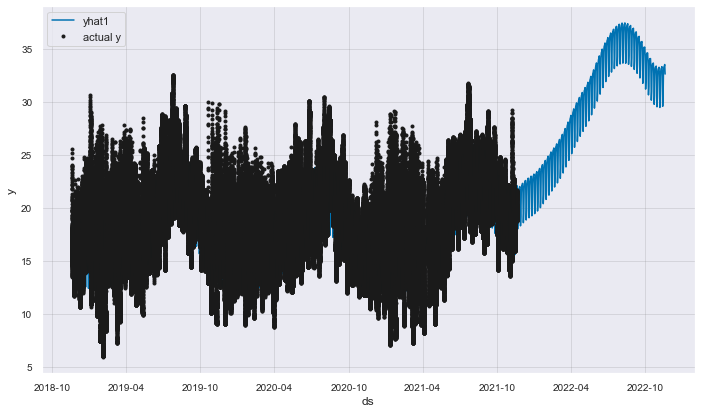

In [122]:
forecast = model.predict(future)
fig1 = model.plot(forecast)

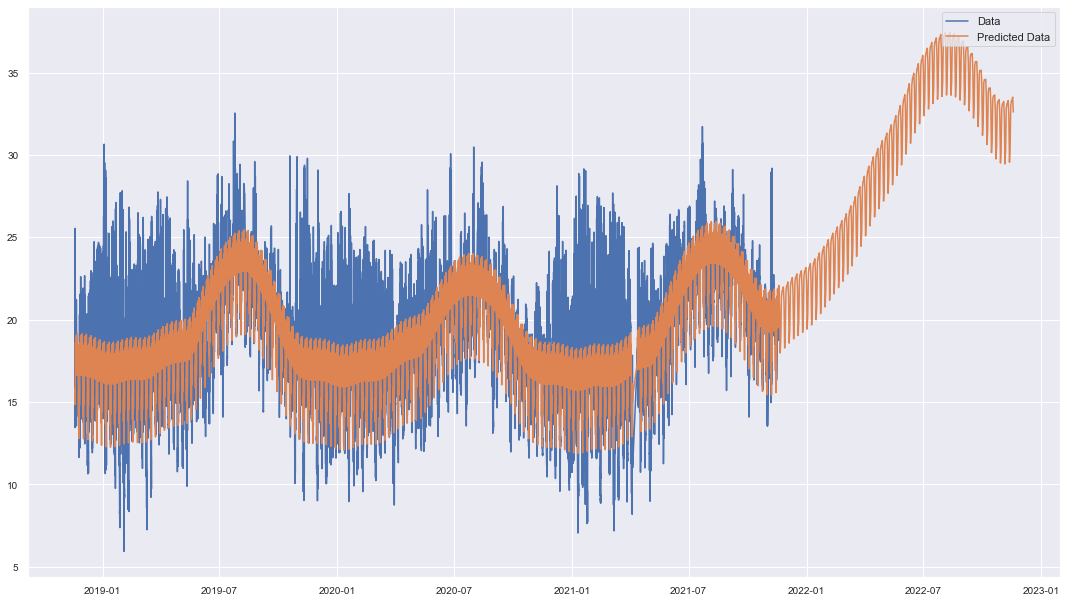

In [123]:
fig, ax = plt.subplots()
ax.plot(forecast["ds"],forecast["y"], label="Data")
ax.plot(forecast["ds"],forecast["yhat1"],label="Predicted Data")
ax.legend(loc = 'upper right')
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()